# ML Project Assignment - Samuele Ceol


## Classification task on heart conditions

## Table of Contents:
* [CHAPTER 0 - INTRODUCTION](#0)
    * [Section 0.1 - Project rationale & objective](#0.1)
    * [Section 0.2 - General dataset information](#0.2)
    * [Section 0.3 - Dataset exploration](#0.3)
* [CHAPTER 1 - DATA CURATION](#1)
* [CHAPTER 2 - DEVELOPMENT OF AN ALGORITHM](#2)
    * [Section 2.1 - Development of a decision tree algorithm](#2.1)
    * [Section 2.2 - Development of a random forest algorithm](#2.2)
* [CHAPTER 3 - ESTABLISHING A BASELINE](#3)
    * [Section 3.1 - Preparing a scoring function](#3.1)
    * [Section 3.2 - Preparing an hyperparameter tuning function](#3.2)
    * [Section 3.3 - Building the Sklearn models](#3.3)
* [CHAPTER 4 - MODELLING USING OUR CUSTOM IMPLEMENTATION](#4)
* [CHAPTER 5 - COMPARING RESULTS](#5)
* [CHAPTER 6 - EXTRA](#6)
    * [Section 6.1 - Pruning with Sklearn implementation of CCP](#6.1)
    * [Section 6.2 - Visual representation of pruned & non-pruned Decision Tree](#6.2)
* [CHAPTER 7 - CONCLUSIONS & FUTURE WORK](#7)

# CHAPTER 0 - INTRODUCTION <a class="anchor" id="0"></a>

## Section 0.1 - Project rationale & objective <a class="anchor" id="0.1"></a>

The initial idea for the development of this projects came from the desire of obtaining a deeper understanding of tree-based algorithms and in how they can be utilized to construct models capable of making predictions in the context of supervised machine learning. One of the best ways to try an have an insight in the inner workings of any algorithm is to make an attempt at the development (from scratch) of a custom version of it. Because of this reason the main focus of this project will be in the development of an implementetion of the CART (Decision Tree) and Random Forest algorithms. Said implementetion will be developed in Python and a baseline will be established using comparable algorithms coming from the Sklearn library in order to assess the general quality of the custom implementetion.

A dataset related to the medical domain (The Cleveland Heart Disease dataset) has been chosen to construct the machine learning models that we are going to use in this project. This particular choice aims at simulating how these types of algorithms could be employed in a real-world scenario. One of the main advantages of tree-based algorithms is their ease of understanding for individuals that are not well versed in the domain of machine learning. The medical field is a perfect example of how Decision Trees could offer an easily understandable solution for medical professionals seeking for help in spotting patients at risk of having an heart condition.

## Section 0.2 - General dataset information <a class="anchor" id="0.2"></a>

### Creators

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

### Donor

David W. Aha (aha '@' ics.uci.edu) (714) 856-8779

### Brief Description

The dataset used in this project is the Cleveland Heart Disease dataset originally published in the UCI Machine Learning Repository. The dataset contains a snapshot of the clinical profile on admission to the hospital of more than 300 patients, together with a binary label indicating if an heart condition was discovered after admission.

### Features

- age: Age in years
- sex: Sex
    - Value 0: female
    - Value 1: male
- cp: Chest pain type
    - Value 0: typical angina
        - Meets all three of the following characteristics:
            - Substernal chest discomfort of characteristic quality and duration
            - Provoked by exertion or emotional stress
            - Relieved by rest and/or nitroglycerine
    - Value 1: atypical angina
        - Meets two out of the three characteristics
    - Value 2: non-anginal pain
        - Meets one or none of the three characteristics
    - Value 3: asymptomatic
- trestbps: Resting blood pressure in mm Hg (millimiters of mercury) on admission to the hospital
- chol: Serum cholestoral in mg/dl
- fbs: Fasting blood sugar > 120 mg/dl
    - Value 0 = false
    - Value 1 = true
- restecg: Resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy (left pumping chamber that has thickened and may not be pumping efficiently) by Estes' criteria
- thalach: Maximum heart rate achieved
- exang: Exercise induced angina
    - Value 0 = no
    - Value 1 = yes
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
    - Value 0: upsloping
    - Value 1: flat
    - Value 2: downsloping
- ca: number of major vessels colored by flourosopy
- thal: Thalassemia (blood disorder in which the body makes an abnormal form or inadequate amount of hemoglobin)
    - Value 0: normal
    - Value 1: fixed defect
    - Value 2: reversable defect
- Condition:
    - Value 0: heart condition not present
    - Value 1: heart condition present

## Section 0.3 - Dataset exploration <a class="anchor" id="0.3"></a>

As a first step, we will start by importing the necessary libraries.

In [1]:
# This block contains all the libraries used in this notebook
import math
import random
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import miceforest as mf

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from operator import itemgetter

### Shape & Column names

Let's now proceed to import the dataset and visualize its shape in order to get a an initial overview regarding the nr of examples and features we will be working with.

In [2]:
df = pd.read_csv('data/heart_cleveland_upload.csv')

df.shape

(303, 14)

In [3]:
print(df.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')


### Changing the default column names

We will now rename our columns in order to make them more understandable.

In [4]:
df.columns = ['age', 'sex', 'chest_pain', 'resting_blood_pressure', 'cholesterol_level', 'fasting_blood_sugar', 'resting_ecg', 'max_heart_rate', 'exercise_induced_angina', 'st_depression', 'st_slope', 'nr_major_vessels', 'thalassemia', 'condition']

### Dataset head

It might also be useful to see how the first examples in our dataset look like. This will help us to get a first idea of the type of processing we will need to perform on the data. In addition, we will also print the data type associated with each feature.

In [5]:
df.head()

,age,sex,chest_pain,resting_blood_pressure,cholesterol_level,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,nr_major_vessels,thalassemia,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1.0,0.0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2.0,0.0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0.0,0.0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1.0,0.0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0.0,0.0,0


### Data types and unique values

In [6]:
df.dtypes

age                          int64
sex                          int64
chest_pain                   int64
resting_blood_pressure       int64
cholesterol_level            int64
fasting_blood_sugar          int64
resting_ecg                  int64
max_heart_rate               int64
exercise_induced_angina      int64
st_depression              float64
st_slope                     int64
nr_major_vessels           float64
thalassemia                float64
condition                    int64
dtype: object

In [7]:
df.nunique()

age                         41
sex                          2
chest_pain                   4
resting_blood_pressure      50
cholesterol_level          152
fasting_blood_sugar          2
resting_ecg                  3
max_heart_rate              91
exercise_induced_angina      2
st_depression               40
st_slope                     3
nr_major_vessels             4
thalassemia                  3
condition                    2
dtype: int64

It might now be interesting to see what are the values associated with the subset of categorical features.

In [8]:
for i in ['sex', 'chest_pain', 'fasting_blood_sugar', 'resting_ecg', 'exercise_induced_angina', 'st_slope', 'nr_major_vessels', 'thalassemia']:
    print(f"{i}: {df[i].dropna().unique()}")

sex: [1 0]
chest_pain: [0 1 2 3]
fasting_blood_sugar: [1 0]
resting_ecg: [2 0 1]
exercise_induced_angina: [0 1]
st_slope: [1 0 2]
nr_major_vessels: [1. 2. 0. 3.]
thalassemia: [0. 2. 1.]


### Missing values

Another important information about our dataset that we will need to consider when curating our data is the presence of null values.

In [9]:
df.isnull().sum()

age                        0
sex                        0
chest_pain                 0
resting_blood_pressure     0
cholesterol_level          0
fasting_blood_sugar        0
resting_ecg                0
max_heart_rate             0
exercise_induced_angina    0
st_depression              0
st_slope                   0
nr_major_vessels           4
thalassemia                2
condition                  0
dtype: int64

As we can see, only the `nr_major_vessels` and `thalassemia` contains examples with missing values. 

### Feature correlation

As a last step in this initial exploration, we will look at the level of correlation between the various features in our dataset.

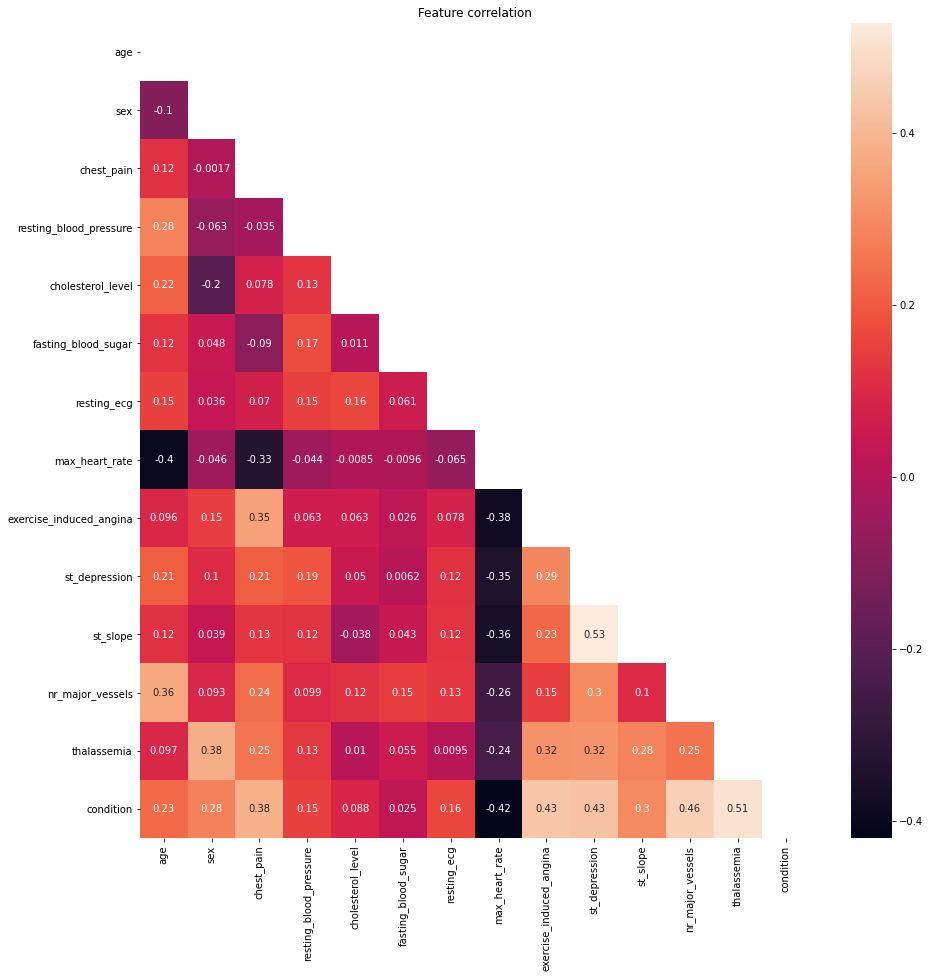

In [10]:
plt.figure(figsize=(15, 15))
plt.title('Feature correlation')

df_corr = df.corr()
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    df_corr, 
    linecolor='black', 
    mask=mask,
    annot=True)
plt.show()

## Section 0.4 - Data distribution <a class="anchor" id="0.3"></a>

Before moving to the data curation phase, we will take a quick look at how the values for all features are distributed in our dataset

### Target class distribution

We will now look at the distribution of heart conditions in our dataset. Knowing how balanced our data is in relation to the `condition` feature is particularly important since we want to ultimately be able to train models capable of predicting the value of this class.

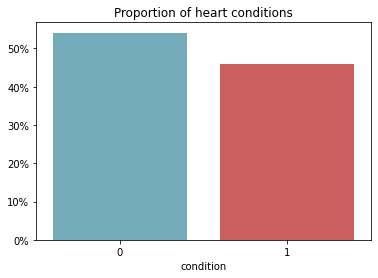

<Figure size 1440x720 with 0 Axes>

In [11]:
def condition_proportion(curr_df, title):
    g = sns.barplot(
        x='condition',
        y='condition',  
        alpha=.75,
        palette=['#3697b5', '#d11313'],
        edgecolor='black',
        linewidth=0,
        data=curr_df,
        estimator=lambda x: len(x) / len(curr_df) * 100,
        ci=None
    )
    
    g.yaxis.set_major_formatter(mtick.PercentFormatter())
    g.set_ylabel('')

    plt.title(title)
    plt.figure(figsize=(20, 10))

condition_proportion(df, "Proportion of heart conditions")

As we can see, the dataset that we are using is slighlty unbalanced. Even though the discrepancy between the two classes is not particularly high, we will still employ some oversampling techniques for the minority class on part of our data in order to successfully train our models. 

### Numerical data distribution

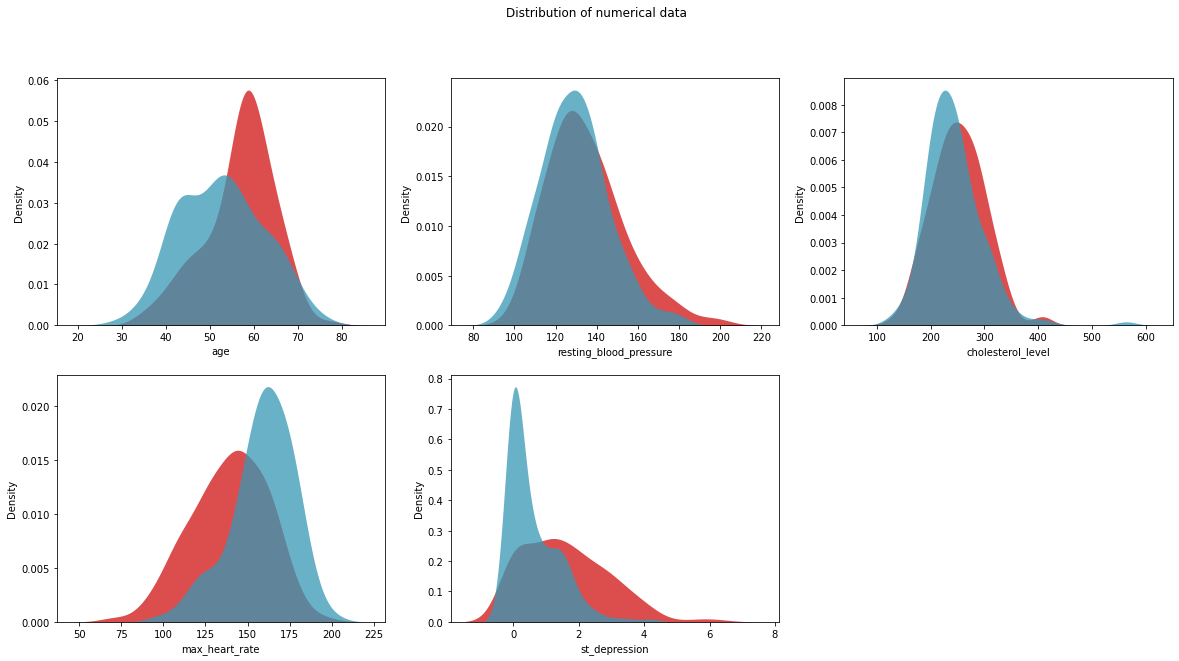

In [12]:
#Since the data is unbalanced, divide it for representation purposes
split_df = df.copy()

split_df = split_df[split_df['nr_major_vessels'].notna()]
split_df = split_df[split_df['thalassemia'].notna()]

split_df.nr_major_vessels = split_df.nr_major_vessels.astype(int)
split_df.thalassemia = split_df.thalassemia.astype(int)

condition_df = split_df[split_df['condition'] == 1]
no_condition_df = split_df[split_df['condition'] == 0]

numeric_features = ['age', 'resting_blood_pressure', 'cholesterol_level', 'max_heart_rate', 'st_depression']
subplot = 231

fig = plt.figure(figsize=(20, 10))

for i in numeric_features:
    plt.subplot(subplot)

    sns.kdeplot(
        x=i,
        alpha=.75,
        color='#d11313', #Red
        shade=True,
        linewidth=0,
        data=condition_df
    )

    sns.kdeplot(
        x=i,
        alpha=.75,
        color='#3697b5', #Blue
        shade=True,
        linewidth=0,
        data=no_condition_df
    )

    subplot += 1

plt.suptitle('Distribution of numerical data')
plt.show()

### Categorical data distribution

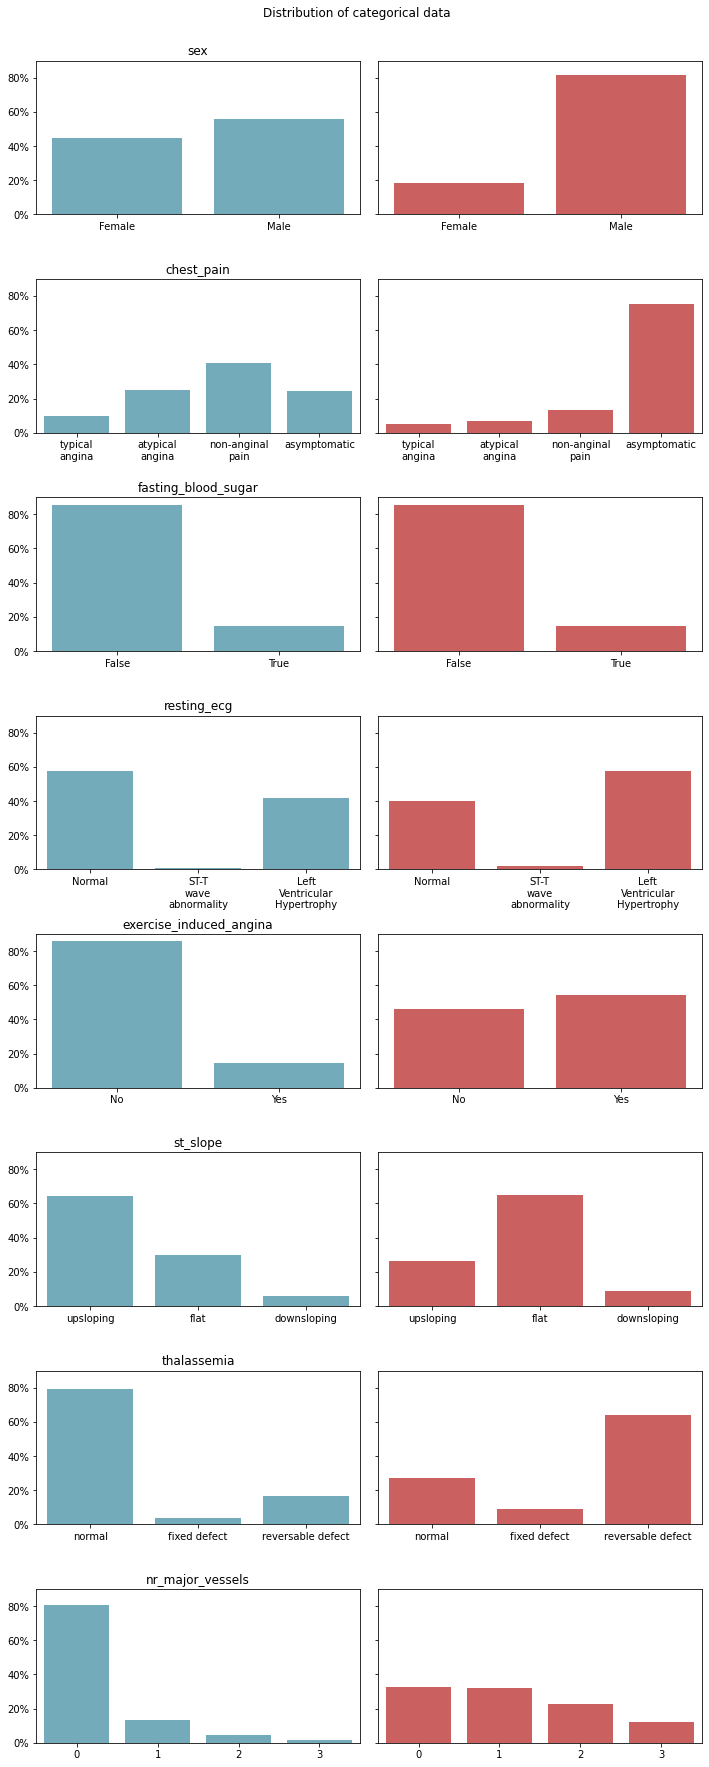

In [13]:
categorical_features = ['sex', 'chest_pain', 'fasting_blood_sugar', 'resting_ecg', 'exercise_induced_angina', 'st_slope', 'thalassemia', 'nr_major_vessels']

categorical_values = [['Female', 'Male'], ['typical\nangina', 'atypical\nangina', 'non-anginal\npain', 'asymptomatic'], ['False', 'True'], ['Normal', 'ST-T\nwave\nabnormality', 'Left\nVentricular\nHypertrophy'], ['No', 'Yes'], ['upsloping', 'flat', 'downsloping'], ['normal', 'fixed defect', 'reversable defect'], ['0', '1', '2', '3']]

fig, ax = plt.subplots(len(categorical_features), 2, figsize=(10, 25), sharey=True)

for i in range(len(categorical_features)):
    feature = categorical_features[i]
    values = categorical_values[i]

    sns.barplot(
        x=feature, 
        y=feature,
        alpha=.75,
        color='#3697b5',
        data=no_condition_df, 
        estimator=lambda x: len(x) / len(no_condition_df) * 100,
        ax=ax[i,0],
        ci=None
    ).set_xticklabels(values)

    if(feature == 'work_type'):
        values.remove('Never worked')

    sns.barplot(
        x=feature, 
        y=feature,
        alpha=.75,
        color='#d11313',
        data=condition_df, 
        estimator=lambda x: len(x) / len(condition_df) * 100,
        ax=ax[i,1],
        ci=None
    ).set_xticklabels(values)

    ax[i,0].set_title(feature)
    ax[i,0].set_ylabel('')
    ax[i,1].set_ylabel('')
    ax[i,0].set_xlabel('')
    ax[i,1].set_xlabel('')
    ax[i,0].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle('Distribution of categorical data')
plt.show()

# CHAPTER 1 - DATA CURATION <a class="anchor" id="1"></a>

We will now start with the process of preparing our dataset for the machine learning algorithms we will later use. We will start off this process by handling the missing values.

### Handling missing values

As we have seen at the beginning of this project, some examples are missing the value for the features `nr_major_vessels` and `thalassemia`. The easiest way to solve this problem would be to simply drop the interested rows or to substitute the missing values with the mean of the `nr_major_vessels` and `thalassemia` features (mean imputation). Mean imputation is a type of univariate imputation, because it only takes into account the feature that we are trying to fill in order to come up with the missing data. A more advanced approach to this issue is to use a multivariate imputation algorithm, which instead will take into consideration the whole set of features to perform the estimation.

We will use an algorithm called Multivariate Imputation by Chained Equation (MICE) in order to complete this task.

In [14]:
kernel = mf.KernelDataSet(df, save_all_iterations=True, random_state=42)
kernel.mice(5) # Nr of iterations
df = kernel.complete_data()

df.nr_major_vessels = df.nr_major_vessels.astype(int)
df.thalassemia = df.thalassemia.astype(int)

### Handling non-binary categorical data

At this point, we are left with three categorical features containing binary data (`sex`, `fasting_blood_sugar` and `exercise_induced_angina`) and five features containing categorical data with a cardinality bigger than two (`chest_pain`, `resting_ecg`, `st_slope`, `nr_major_vessels` and `thalassemia`).

During the development of our Decision Tree and Random Forest algorithms, we will work with binary trees. Binary trees are able to handle binary categorical data (values 0 and 1) without any particular issue.

When a feature has a cardinality bigger than two, encoding it as an integer will impose an order on its values. This would be correct when working with ordinal categorical values (e.g low/medium/high becomes 0/1/2), but fails completely in our case since no order can be established between the categories of our features.

Because of this reason we will further process these two features in order to make them more suitable to use in our machine learning algorithms.

We will approach this issue by using One-hot encoding. This technique will effectively turn a single categorical feature into multiple binary ones. The number of newly created (dummy) binary features corresponds to the number of categories in the original feature. 

When using One-hot encoding in the context of tree-based algorithms we have to consider that:

>One-hot encoding categorical variables with high cardinality can cause inefficiency in tree-based ensembles. Continuous variables will be given more importance than the dummy variables by the algorithm which will obscure the order of feature importance resulting in poorer performance.

- One-Hot Encoding is making your Tree-Based Ensembles worse, here’s why. Rakesh Ravi

Since the cardinalities of the features we are working with are fairly low (<=4), this issue will more than likely not affect us.

In [15]:
high_cardinality_cols = ['chest_pain', 'resting_ecg', 'st_slope', 'nr_major_vessels', 'thalassemia']
df = pd.get_dummies(df, columns=high_cardinality_cols, drop_first=True)
df

,age,sex,resting_blood_pressure,cholesterol_level,fasting_blood_sugar,max_heart_rate,exercise_induced_angina,st_depression,condition,chest_pain_1,...,chest_pain_3,resting_ecg_1,resting_ecg_2,st_slope_1,st_slope_2,nr_major_vessels_1,nr_major_vessels_2,nr_major_vessels_3,thalassemia_1,thalassemia_2
0,69,1,160,234,1,131,0,0.1,0,0,...,0,0,1,1,0,1,0,0,0,0
1,69,0,140,239,0,151,0,1.8,0,0,...,0,0,0,0,0,0,1,0,0,0
2,66,0,150,226,0,114,0,2.6,0,0,...,0,0,0,0,1,0,0,0,0,0
3,65,1,138,282,1,174,0,1.4,1,0,...,0,0,1,1,0,1,0,0,0,0
4,64,1,110,211,0,144,1,1.8,0,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,38,1,138,175,0,173,0,0.0,0,0,...,0,1,0,0,1,0,0,0,0,1
299,38,1,138,175,0,173,0,0.0,0,0,...,0,1,0,0,1,0,0,0,0,1
300,43,1,132,247,1,143,1,0.1,1,0,...,0,0,0,1,0,1,0,0,0,1
301,53,0,128,216,0,115,0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Feature scaling (Standardizing continuous data)

Some machine learning algorithms are highly sensitive to differing degrees of magnitudes between features. Said algorithms (like KNN, K-Means and SVM) will tend to give an higher importance towards features having an higher magnitude.
There are two approaches to address this problem: normalization and standardization.

Normalization is a technique in which values are rescaled so that they end up in a range between 0 and 1. The formula for feature normalization is as follows:

$$ X' = \frac{X - X_{min}}{X_{max} - X_{min}} $$

On the other hand, standardization (or Z-score normalization) rescales the values for a given feature such that it will have the properties of standard normal distribution around the mean (that takes value 0) and the standard deviation (that takes value 1). The formula for standardization is as follows:

$$ X' = \frac{X-\mu}{\sigma} $$

In the context of this project, feature scaling is a completely optional step. Tree-based algorithm are not touched by this issue since they decide upon a split by looking at features "in isolation". Because of this fact, we will obtain the same results even without running the following code block.

It was deemed appropiate to perform this step in order to prepare the data for future work related to this project.

In [16]:
# Feature scaling (Standardization) - Removing the median and scaling the data according to the quantile range 
cols_to_scale = ['age', 'resting_blood_pressure', 'cholesterol_level', 'max_heart_rate', 'st_depression']
ss = StandardScaler()
df[cols_to_scale] = ss.fit_transform(df[cols_to_scale])

### Train - Test Split

Before addressing the issue related to the slight unbalance in our dataset, we will first create our training and testing subsets. It is important to remember that the oversampling technique perfomed in the next subsection is only applied to the training set.

The parameter `stratify` set to our target variable will make sure that the testing split will have the same ratio of the target class that we have found in the original dataset.

In [17]:
X = df[['age', 'sex', 'resting_blood_pressure', 'cholesterol_level',
       'fasting_blood_sugar', 'max_heart_rate', 'exercise_induced_angina',
       'st_depression', 'chest_pain_1', 'chest_pain_2',
       'chest_pain_3', 'resting_ecg_1', 'resting_ecg_2', 'st_slope_1',
       'st_slope_2', 'nr_major_vessels_1', 'nr_major_vessels_2',
       'nr_major_vessels_3', 'thalassemia_1', 'thalassemia_2']]
y = df[['condition']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df['condition'], random_state=42)

### Handling unbalanced data (oversampling with SMOTE)

As already seen at the beginning of this project, the dataset we are working with is slightly unbalanced. This is a fairly common occurence when working with medical data, and in our case it means that the `condition` attribute of our training examples will be overrepresented by a majority class (0 in our case) that will cause our model to be slightly biased towards it (i.e. in more extreme cases the model would tend to see the minority class as data noise). 

A technique that we can use to address this problem is to oversample our minority class by synthesizing new (training set) entries. The simplest way to implement oversampling would be to randomly duplicate existing instances of the minority class. A more interesting way to solve this problem is to use SMOTE (Synthetic Minority Oversampling Technique). Instead of simply duplicating existing data objects, SMOTE will select an object from the minority class. The algorithm will then select another object from the pool of its k-nearest neighbors. A new synthetic example is then created at a random point between the two selected examples. The process is repeated until the classes in the dataset have been balanced.

<img src="./images/SMOTE.png" alt="k-fold" width="600"/>

Shape before SMOTE: (212, 20)
Shape after SMOTE: (230, 20)


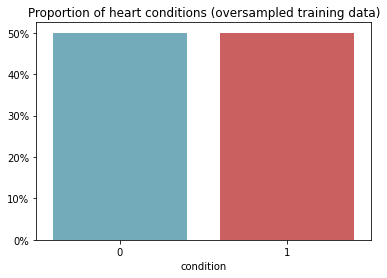

<Figure size 1440x720 with 0 Axes>

In [18]:
oversample = SMOTE(random_state=42)
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

oversampled_df = X_train_SMOTE.assign(condition = y_train_SMOTE)
condition_proportion(y_train_SMOTE, "Proportion of heart conditions (oversampled training data)")
print("Shape before SMOTE: " + str(X_train.shape))
print("Shape after SMOTE: " + str(X_train_SMOTE.shape))

# CHAPTER 2 - DEVELOPMENT OF AN ALGORITHM <a class="anchor" id="2"></a>

## Section 2.1 - Development of a decision tree algorithm <a class="anchor" id="2.1"></a>

The algorithm that has been chosen to be implemented for the classification task of this projects is called CART (short for Classification and Regression Trees). An improved version of this algorithm is used by the `DecisionTreeClassifier` and `RandomForestClassifier` of the `sklearn.tree` library.

### CART (Classification and Regression Trees)

### Building the tree

CART is an algorithm that recursively builds binary trees (branching factor for root and inner nodes = 2) by searching in a partition the combination of feature and threshold values that will maximize the reduction in impurity obtained by splitting a given partition using a selected split candidate. Like many tree-based algorithms (like ID3, C4.5), CART builds the tree structure from the top-down by starting from a `root` partition which containins all the training data. This recursive split (from parent partition to left and right child nodes) is what ultimately allows the algorithm to build the tree structure. 

### Searching for a split candidate

For each newly created parittion, CART will look at each combination of feature and threshold in order to find a split candidate. For every feature containing `K` different values, we will always have `K-1` possible thresholds. It can also be decided (by changing the value of `max_features`) to search for a split only in a subset of randomly sampled features, this is the default behavior when a tree is initialized from the `RandomForestClassifier` (where `max_features = sqrt`).

Before searching for a possible split, the implemented algorithm will (as a first step) sort the partition entries based on the values of the selected feature. Sorting is fairly expensive, but it allows the algorithm to easily search for all thresholds (within a given feature) in linear time. The algorithm will then proceed to traverse the list of sorted examples and to evaluate all midpoints between two (different) adjecent values as a possible threshold. The reduction in impurity that would be obtained by splitting at the currently selected threshold is compared with the maximum reduction that has been registered so far for the current partition. If the current reduction is bigger than the previous best one, the details of the best split candidate are updated.

### Stopping condition

In CART, the splitting process is recursively repeated for each newly created node until a stopping condition is met. The decision to stop the splitting process for a given node is triggered when: 
- The partition is pure (i.e. all the examples in the partition have the same class)
- No possible split can be imposed to the current partition (i.e. All examples only have a single value per feature)
- The (user defined) maximum depth (`max_depth`) has been reached
- The threshold for the reduction is impurity (`min_impurity_decrease`) cannot be satisfied by any split candidate
- The threshold for the minimum nr of examples needed to split a partition (`min_samples_split`) is not met
- The impurity for the current partition is below a given threshold (`min_impurity_split`) 
- The current partition cannot produce two children with the required minimum nr of entries (`min_samples_leaf`)

Whenever a stopping condition is reached, the interested partition is turned into a leaf node. Majority voting is performed in order to decide what is the predicted value of the newly created leaf.

### Split strategy

For this algorithms implementation two strategies have been offered to asses the quality of a split candidate (feature+threshold): `gini` and `entropy`

Initializing our `CustomDecisionTreeClassifier` with `criterion = gini` will cause our algorithm to use the Gini Index as a starting metric to evaluate the reduction in impurity brought upon by a given split candidate. 

The Gini Index for a partition D containing examples with C different classes is calculated as follows:

$$ Gini(D) = 1 - \sum \limits _{i=1} ^{C} (p _{i}) ^{2} $$

When considering a split candidate A (feature+threshold) for a partition D, we calculate the weighted sum of impurities of the resulting child partitions D1 and D2 as follows:

$$ Gini _{A} (D) = \frac{size(D _{1})}{size(D)} Gini(D _{1}) + \frac{size(D _{2})}{size(D)} Gini(D _{2})$$

The reduction of impurity is then simply:

$$ \Delta Gini(A) = Gini(D) - Gini _{A} (D) $$

Alternatively, the algorithm can be initialized with `criterion = entropy` to use the Information gain as a metric for the reduction in impurity.

The entropy of a partition D containing examples with C different classes is calculated as follows:

$$ Entropy(D) = - \sum \limits _{i=1} ^{C} p _{i} log _{2} (p _{i}) $$

The weighted sum of entropies for child partitions D1 and D2 originating from D via a split candidate A is:

$$ Entropy _{A} (D) = \frac{size(D _{1})}{size(D)} Entropy(D _{1}) + \frac{size(D _{2})}{size(D)} Entropy(D _{2})$$

The Information Gain is then simply:

$$ Gain(A) = Entropy(D) - Entropy _{A} (D) $$

### Pruning

Often times when working with tree based algorithms we end up constructing trees with some branches reflecting anomalies (e.g. outliers) of the data that was used to construct them. This leads to overfitting and hinders the capacity of the model to generalize well to new data. In order to tackle this issue we will use a techingue called pruning. Pruning entails cutting out certain branches of the tree in order to reduce the model size and improve its performance. We distinguish two types of pruning: pre-pruning and post-pruning.

Pre-pruning (or forward pruning or early stopping) is a type of pruning which prevents the creation of non-significant branches. Pre-pruning is achieved by tuning parameters such as `max_depth`, `min_impurity_decrease`, `min_impurity_split`, `min_samples_split` and `min_samples_leaf` to avoid splits that would otherwise occur during the creation of the tree.

Post-pruning is a type of pruning that removes sub-trees (by replacing them with leaf nodes) once they have already been grown. A popular algorithm used for post pruning is the Cost Complexity Pruning algorithm. Due to time constraints, CCP has not been implemented in our custom implementation of the CART algorithm. A section showing how the Sklearn implementation of CCP can be used to improve the performance of a tree-based model can be seen at the end of this project.

### Partition class

To represent the structure of a node in our Decision Tree, it has been decided to create a `Partition` class that will contain all the information related to a given node.
Root and inner nodes will contain information regarding the chosen split candidate (`split_feature`, `split_value`), the level of impurity (`impurity_part`), the reduction of impurity that has been obtained with the chosen split candidate (`impurity_delta`) and the weighted sum of impurities of the child nodes obtained with the chosen split candidate (`impurity_feature_example`).
Additionally, the non-leaf nodes also have populated pointers to their child partitions (`left_part` and `right_part`). This characteristics of the partition class is what allows us to traverse the full-length of the tree by starting from the root node and jumping from child to child until a leaf node is reached.

For both root/inner nodes and leaf nodes we have information regarding the predicted class values (`prediction`) which is obtained by majority voting, and the class distribution (i.e. the number of examples for each class value, represented by `counter`).

### Predicting a class

Predicting a class value from a trained model is simply a matter of traversing the three from root to leaf. Non-leaf nodes contain information regarding the feature (`split_feature`) and threshold (`split_value`) we have to check in order to decide if we want to move to the left (example value <= partition threshold) or right (example value > partition threshold) child from the current partition. Once a leaf node is reached, the algorithm stops and checks the predicted value (`prediction`) in order to decide what the predicted class value will be for the current example.

In [19]:
class Partition:
    '''
    Class used to represent a partition
    Partitions act as nodes in the Decision Tree

    Attributes
    ----------
    split_feature: str
        Feature chosen for splitting the partition
    split_value: float
        (Threshold) Value chosen for splitting the partition
    impurity_part: float
        Impurity of the current partition
    impurity_delta: float
        Reduction in impurity by splitting using split_feature and split_value
    impurity_feature_example: float
        Weighted sum of impurities for the partitions resulting from a split at split_feature and split_value
    prediction: float
        Predicted value (majority class) at the current partition
    counter: collections.Counter
        Counter for each class in the parition
    '''
    def __init__(self, 
                 split_feature, 
                 split_value, 
                 impurity_part,
                 impurity_delta, 
                 impurity_feature_example, 
                 prediction,
                 counter):
        self.split_feature = split_feature
        self.split_value = split_value
        self.impurity_part = impurity_part
        self.impurity_delta = impurity_delta
        self.impurity_feature_example = impurity_feature_example
        self.prediction = prediction
        self.counter = counter
        self.left_part = None
        self.right_part = None

In [20]:
class CustomDecisionTreeClassifier:
    '''
    Class used to model the decision tree

    Attributes
    ----------
    criterion: str
        Strategy used to calculate the impurity of a partition
        'gini' (for gini index) or 'entropy' (for information gain)
    max_depth: int
        Maximum total depth of the tree. Root node is at depth 1
    min_impurity_decrease: float
        Threshold for the reduction in impurity needed to split a partition
        If the values is not met, the interested partition is turned into a leaf node
    min_impurity_split: float
        Impurity threshold below which a partition is turned into a leaf node 
    min_samples_split: int
        Threshold for the nr of examples needed to split a partition
        If the values is not met, the interested partition is turned into a leaf node
    max_features: str, int
        The number of features (randomly) considered at each node in order to find a split point
        Note: 
            If no valid split point can be found with the initially sampled features, before turning the parition into 
            a leaf node the system will try to sample additional features until at least one combination of 
            'split_feature' and 'split_value' is found or until all possible features are exhausted
        Can be manually set (int) or as follows (str):
            'None' considers all the features of in training set
            'sqrt' considers the square root of the total nr of features in the training set
            'log2' considers the log base 2 of the total nr of features in the training set
    min_samples_leaf: int
        The minimum nr of entries required for a leaf node
        A split candidate is considered only if it creates two child nodes that respect this parameter
    '''
    def __init__(self, *,
                 criterion = 'gini',
                 max_depth = None, 
                 min_impurity_decrease = 0.0,
                 min_impurity_split = None,
                 min_samples_split = 2,
                 max_features = None,
                 min_samples_leaf = 1):
        self.criterion = criterion
        self.max_depth = max_depth 
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = 0
        self.root = None

    def fit(self, 
            X, 
            y):
        '''
        Starts the process of building a Decision Tree from a training set

        Parameters
        ----------
        X: pandas.core.frame.DataFrame, numpy.ndarray
            The training examples
        y: pandas.core.frame.DataFrame, numpy.ndarray
            The training class labels

        Returns
        ----------
        self: CustomDecisionTreeClassifier
            The fitted estimator
        '''
        X, y = self.data_to_numpy(X,y)
        self.n_classes = len(np.unique(y))
        self.root = self.build_tree(X, y, self.max_depth)
        return self

    @staticmethod
    def data_to_numpy(X,
                      y = None):
        '''
        Converts input dataframes to numpy arrays

        Parameters
        ----------
        X: pandas.core.frame.DataFrame, numpy.ndarray
            The training examples
        y: pandas.core.frame.DataFrame, numpy.ndarray
            The training class labels

        Returns
        ----------
        X: numpy.ndarray
            The training examples converted to a numpy array
        y: numpy.ndarray
            The training class labels converted to a (flattened) numpy array
        '''
        if(type(X) != np.ndarray):
            X = X.to_numpy()
        if((y is not None) and (type(y) != np.ndarray)):
            y = y.to_numpy()

        if(y is not None):
            return X, y.flatten()
        else:
            return X

    def build_tree(self, 
                   X, 
                   y, 
                   depth):
        '''
        Recursively builds a Decision Tree starting from a training set.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: numpy.ndarray
            The training class labels
        depth: int
            Depth counter
            Used as stop condition for the recursive call when `max_depth` is defined for the Decision Tree

        Returns
        -------
        curr_part: Partition
            The root partition (node) of the Decision Tree
        '''
        # Majority class is set as the predicted value for the current partition
        counter = Counter(y)
        prediction = counter.most_common(1)[0][0]

        # Update depth value
        if self.max_depth:
            if depth > 0:
                depth -= 1 
            else:
                return Partition(None, None, None, None, None, prediction, counter) # Return as leaf

        # Check partition size
        if y.size < self.min_samples_split:
            return Partition(None, None, None, None, None, prediction, counter) # Return as leaf

        split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example = self.find_split(X, y)
        curr_part = Partition(split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example, prediction, counter)

        if(split_feature is not None):
            # Temporarely create a merged df in order to filter features and classes together
            merged_df = np.append(X, np.vstack(y), axis=1)
            
            merged_df_left = merged_df[merged_df[:,split_feature] <= split_value]
            merged_df_right = merged_df[merged_df[:,split_feature] > split_value]

            curr_part.left_part = self.build_tree(
                merged_df_left[:, :-1], 
                merged_df_left[:, -1], 
                depth) # Left

            curr_part.right_part = self.build_tree(
                merged_df_right[:, :-1], 
                merged_df_right[:, -1], 
                depth) # Right  

        return curr_part

    def predict(self, 
                X):
        '''
        Predicts the class value (label) for each input example
        The tree is traversed for each provided example

        Parameters
        ----------
        X: numpy.ndarray, pandas.core.frame.DataFrame
            The examples to predict the class for

        Returns
        ----------
        y: numpy.ndarray
            The predicted class labels
        '''
        X = self.data_to_numpy(X)
        y = []

        for example in X:
            curr_part = self.root

            while curr_part.right_part:
                if example[curr_part.split_feature] <= curr_part.split_value:
                    curr_part = curr_part.left_part
                else:
                    curr_part = curr_part.right_part
            y.append(curr_part.prediction)

        return np.array(y)


    def predict_proba(self, 
                      X):
        '''
        Predicts the probability of each class value (label) for each input example

        Parameters
        ----------
        X: numpy.ndarray, pandas.core.frame.DataFrame
            The examples to predict the class for

        Returns
        ----------
        y: numpy.ndarray
            The probabilities for each class label
        '''
        X = self.data_to_numpy(X)
        y = []

        for example in X:
            curr_part = self.root

            while curr_part.right_part:
                if example[curr_part.split_feature] <= curr_part.split_value:
                    curr_part = curr_part.left_part
                else:
                    curr_part = curr_part.right_part

            temp = []

            for i in range(self.n_classes):
                if(i == curr_part.prediction):
                    temp.append(1.0)
                else:
                    temp.append(0.0)

            y.append(temp)

        return np.array(y)

    # Both gini index and entropy/information gain are measures of the impurity of a node.
    def calc_impurity(self, 
                      class_occ, 
                      size_part):
        '''
        Calculates the impurity of a partition based on the chosen strategy

        Parameters
        ----------
        class_occ: Counter
            Nr of occurrences of each class value 
        size_part:
            Nr of examples in the current partition
        Returns
        ----------
        ret:
            The impurity value of the partition
        '''
        if self.criterion == 'gini':
            return (1 - sum((class_occ[curr_class]/size_part)**2 for curr_class in class_occ))
        elif self.criterion == 'entropy':
            ret = 0
            for curr_class in class_occ:
                if class_occ[curr_class]/size_part > 0:
                    ret -= class_occ[curr_class]/size_part * math.log(class_occ[curr_class]/size_part, 2)
            return ret

    def find_split(self, 
                    X, 
                    y):
            '''
            Finds the best split feature and threshold for a given partition

            Parameters
            ----------
            X: pandas.core.frame.DataFrame
                The training examples
            y: pandas.core.frame.DataFrame
                The training class labels

            Returns
            ----------
            split_feature: str
                Feature chosen for splitting the partition
            split_value: float
                (Threshold) Value chosen for splitting the partition
            impurity_delta: float
                Reduction in impurity by splitting using `split_feature` and `split_value`
            impurity_feature_example: float
                Weighted sum of impurities for the partitions resulting from a split at `split_feature` and `split_value`
            '''
            # Initialize the return values
            split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example = None, None, None, None, None
            
            # Calculate the occurences of each class in the partition
            class_occ_part = Counter(y)

            # Return if the partition is pure
            if(sum(class_occ_part[i] > 0 for i in class_occ_part) == 1):
                return split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example

            # Calculate the impurity of the current partition
            size_part = y.size
            impurity_part = self.calc_impurity(class_occ_part, size_part)
            impurity_delta = 0
            
            # Return if below impurity threshold
            if((self.min_impurity_split is not None) and (impurity_part < self.min_impurity_split)):
                return split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example

            # Sample the features to consider for the split
            X_rows, X_cols = X.shape
            n = X_cols

            if(self.max_features == 'sqrt'):
                n=round(math.sqrt(X_cols))
            elif(self.max_features == 'log2'):
                n=round(math.log2(X_cols))
            elif((self.max_features is not None) and (self.max_features <= X_cols)):
                n=self.max_features

            sampled_features = sorted(random.sample(range(0, X_cols), n))

            # Loop through all features
            for feature in sampled_features:
                # Skip ahead if the feature has only one value
                if len(np.unique(X[:,feature])) == 1:
                    continue

                # Sort the examples in increasing order for the selected feature
                # Consider the midpoint between two (different) adjecent values as a possible split point
                feature_sorted, y_sorted = zip(*sorted(zip(X[:,feature], y), key=itemgetter(0)))

                # Go through the sorted feature while keeping track of class occurences on each side (/partition)
                class_occ_left = Counter()
                for i in range(self.n_classes):
                    class_occ_left[i] = 0 # Left partition starts as empty (all class counters are set to 0)

                class_occ_right = class_occ_part.copy() # Same as occurences of each class in the partition

                for example in range(1, size_part):
                    example_class = y_sorted[example-1]

                    # Increment the example class on the left, decrement it on the right
                    class_occ_left[example_class] += 1
                    class_occ_right[example_class] -= 1

                    # Skip ahead if two adjacent values are equal
                    if feature_sorted[example] == feature_sorted[example - 1]:
                        continue

                    size_left = example
                    size_right = size_part - example

                    # Skip if the threshold does not respect the min_samples_leaf parameter
                    if(size_left < self.min_samples_leaf or size_right < self.min_samples_leaf):
                        continue

                    # Calculate the impurity of each side
                    impurity_left = self.calc_impurity(class_occ_left, size_left)
                    impurity_right = self.calc_impurity(class_occ_right, size_right)
                    
                    # Weighted sum of impurities (with selected feature at current example)
                    curr_impurity_feature_example = ((size_left/size_part) * impurity_left) + ((size_right/size_part) * impurity_right)

                    # Reduction in impurity with current split
                    curr_impurity_delta = impurity_part - curr_impurity_feature_example 

                    if(self.min_impurity_decrease and curr_impurity_delta < self.min_impurity_decrease):
                        continue

                    if(curr_impurity_delta > impurity_delta):
                        split_feature = feature
                        split_value = (feature_sorted[example] + feature_sorted[example-1]) / 2
                        impurity_delta = curr_impurity_delta
                        impurity_feature_example = curr_impurity_feature_example

                # If no split point was found when using a random subset of features, try to randomly sample a new one
                if((len(sampled_features) != X_cols) and (split_feature is None) and (feature == sampled_features[-1])):
                    sampled_features.append(random.sample(set(range(0, X_cols)) - set(sampled_features), 1)[0])

            return split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example

## Section 2.2 - Development of a random forest algorithm <a class="anchor" id="2.2"></a>

Now that we have a way to build binary tree using our implementation of the CART algorithm, we are ready to move a step further by implementing a Random Forest classifier (`CustomRandomForestClassifier`) that will use our `CustomDecisionTreeClassifier` as the basic building block to perform ensemble learning.

### Building a forest

Building a forest is a fairly straightforward process in which a set `CustomDecisionTreeClassifier` equal to the value defined by the `n_estimators` parameter are initialized. Using the same input data for all trees and considering the same features for all node splits would create a set of identical models. Since an ensemble of nearly identical trees is fairly useless, Random Forest uses two techniques to ensure that all the models built as part of the forest are slightly different from one another:

- Feature randomness
- Bootstrap Aggregation (Bagging)

### Feature randomness

As we have seen in the previous section, setting the `max_features` variable of the `CustomDecisionTreeClassifier` influences how many features are randomly sampled when searching for a potential split in a partition. This particular parameter will allow the algorithm to increment the range of diversity between the trees that are part of the forest.

This random sampling of features is done at the node level, NOT at the tree level. Early implementations of the random forest algorithms used a technique called “random subspace method” where the random subset of features was provided at the tree level:

>“Our method relies on an autonomous, pseudo-random procedure to select a small number of dimensions from a given feature space …”

 - Ho, Tin Kam. “The random subspace method for constructing decision forests.” IEEE transactions on pattern analysis and machine intelligence 20.8 (1998): 832-844

Just like the implementation shown in this project, modern (state of the art) random forest algorithms use random sampling of features at the node level. This approach allows the algorithm to learn the relationship between different features in a more diversified way. 

This means that each tree can work with the full set of features of the training data.

>“… random forest with random features is formed by selecting at random, at each node, a small group of input variables to split on.”

 - Breiman, Leo. “Random Forests” Machine learning 45.1 (2001): 5-32.

### Bagging (or bootstrap aggregation)

<img src="./images/bagging.png" alt="k-fold" width="400"/>

### Bootstrapping

In addition to using a random subset of feature for each split, the trees in the Random Forest are also constructed using slightly different training data. This is achieved via a technique called bootstrapping. Bootstrapping uses sampling with replacement to construct a new version of the training dataset for every tree in the forest. Bootstrapping entails randomly sampling examples from the original dataset until a ratio size (`max_samples`) is reached. Sampling with replacement simply means that the same entries can be sampled multiple times from the original dataset.

### Predicting a class (Aggregation)

Once all the models in the forest have been constructed, we can start predicting labels for new data.
The technique used by the Random Forest algorithm to predict a class label is pretty straightforward. The algorithm will run the prediction (exapleined in the previous section) for every tree in the forest. Majority voting is then applied on the list of predictions and the most frequent class value is then chosen as the return value.

### A note on pruning

Trees tend to be low-bias, high-variance models. This is the reason why, when building a single decision tree, employing pruning techniques is usually helpful in order to remove those branches that reflect noise and outliers in the training data.

Random Forest uses feature randomness and bagging to "de-correlate" trees so that they are not overly similar. Predictions are then made considering all trees in the ensemble. This has the effect of mitigating this high variance and helps to avoid overfitting. Because of this reason, the benefits of emplying pruning techniques are usually greatly reduced when working with a Random Forest.

In [21]:
class CustomRandomForestClassifier:
    '''
    Class used to model the random forest

    Attributes
    ----------
    n_estimators: int
        Controls the nr of trees in the forest
    bootstrap: bool
        Decides whether bootstrapping is used for the trees input data
        When set to False, the whole dataset is used for each tree in the forest
    max_samples: float
            The ratio size of the bootstrapping sample
    criterion: str
        Strategy used to calculate the impurity of a partition in a tree
        Either 'gini' (for gini index) or 'entropy' (for information gain)
    max_depth: int
        Maximum total depth of the trees. Root node is at depth 1
    min_impurity_decrease: float
        Threshold for the reduction in impurity needed to split a partition in a tree
        If the values is not met, the interested partition is turned into a leaf node
    min_impurity_split: float
        Impurity threshold below which a partition is turned into a leaf node 
    min_samples_split: int
        Threshold for the nr of examples needed to split a partition in a tree
        If the values is not met, the interested partition is turned into a leaf node
    max_features: str
        The number of features (randomly) considered at each split in a tree
        'None' considers all the features in the training set
        'sqrt' considers the square root of the total nr of features in the training set
        'log2' considers the log base 2 of the total nr of features in the training set
    min_samples_leaf: int
        The minimum nr of entries required for a leaf node
        A split candidate is considered only if it creates two child nodes that respect this parameter
    '''
    def __init__(self, *,
                 n_estimators = 100,
                 bootstrap = True,
                 max_samples = 1.0,
                 criterion = 'gini',
                 max_depth = None, 
                 min_impurity_decrease = 0.0, 
                 min_impurity_split = None,
                 min_samples_split = 2,
                 max_features = 'sqrt',
                 min_samples_leaf = 1):
        self.criterion = criterion
        self.max_depth = max_depth # Root depth is 0
        self.bootstrap = bootstrap
        self.max_samples = max_samples
        self.n_estimators = n_estimators
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = 0
        self.forest = []

    def fit(self, 
            X, 
            y):
        '''
        Starts the process of building a Random Forest

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: numpy.ndarray
            The training class labels

        Returns
        ----------
        self: CustomRandomForestClassifier
            The fitted estimator
        '''
        X, y = self.data_to_numpy(X, y)

        # Flush old forest
        if len(self.forest) > 0:
            self.forest = []

        self.n_classes = len(np.unique(y))

        for i in range(self.n_estimators):
            curr_tree = CustomDecisionTreeClassifier(criterion = self.criterion,
                                                     max_depth = self.max_depth,
                                                     min_impurity_decrease = self.min_impurity_decrease,
                                                     min_impurity_split = self.min_impurity_split,
                                                     min_samples_split = self.min_samples_split,
                                                     max_features = self.max_features,
                                                     min_samples_leaf = self.min_samples_leaf)

            if self.bootstrap:
                curr_X, curr_y = self.bootstrap_sample(X, y, self.max_samples)
                curr_tree.fit(curr_X, curr_y)
            else:
                curr_tree.fit(X, y)

            self.forest.append(curr_tree)

        return self

    @staticmethod
    def data_to_numpy(X,
                      y = None):
        '''
        Changes input dataframes to numpy arrays

        Parameters
        ----------
        X: pandas.core.frame.DataFrame, numpy.ndarray
            The training examples
        y: pandas.core.frame.DataFrame, numpy.ndarray
            The training class labels

        Returns
        ----------
        X: numpy.ndarray
            The training examples converted to a numpy array
        y: numpy.ndarray
            The training class labels converted to a (flattened) numpy array
        '''
        if(type(X) != np.ndarray):
            X = X.to_numpy()
        if((y is not None) and (type(y) != np.ndarray)):
            y = y.to_numpy()

        if(y is not None):
            return X, y.flatten()
        else:
            return X

    @staticmethod
    def bootstrap_sample(X, 
                         y, 
                         ratio = 1):
        '''
        Creates a new dataset (X_bootstrap, y_bootstrap) by randomly selecting examples from the original dataset (X, y) 
        until a ratio size is reached
        The same examples from the original dataset may be sampled multiple times (sampling with replacement)

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: numpy.ndarray
            The training class labels
        ratio: float
            The ratio size of the sample

        Returns
        ----------
        X_bootstrap: pandas.core.frame.DataFrame
            New feature dataframe created from the sampled entries
        y_bootstrap: numpy.ndarray
            New class dataframe created from the sampled entries
        '''
        # Temporarily create a merged df to sample from
        merged_df = np.append(X, np.vstack(y), axis=1)

        samples_idx = np.random.choice(merged_df.shape[0], round(merged_df.shape[0]*ratio))
        merged_df[samples_idx]

        X_bootstrap = merged_df[:, :-1]
        y_bootstrap = merged_df[:, -1]

        return X_bootstrap, y_bootstrap

    def predict(self, 
                X):
        '''
        Predicts the class value (label) for each input example

        Parameters
        ----------
        X: numpy.ndarray, pandas.core.frame.DataFrame
            The examples to predict the class for

        Returns
        ----------
        y: numpy.ndarray
            The predicted class labels
        '''
        X = self.data_to_numpy(X)
        y_forest = [] # Each index is the list of predictions from one tree

        for tree in self.forest:
            y_forest.append(tree.predict(X))

        # Zip together prediction for same entry over different trees, extract most common class (majority voting)
        return np.array(list(map(lambda i: Counter(i).most_common(1)[0][0], zip(*y_forest))))
    
    def predict_proba(self,
                      X):
        '''
        Predicts the probability of each class value (label) for each input example
        This probability is based on the output of the `predict` method for each tree in the forest for a
        given example

        Parameters
        ----------
        X: numpy.ndarray, pandas.core.frame.DataFrame
            The examples to predict the class for

        Returns
        ----------
        y: numpy.ndarray
            The probabilities for each class label
        '''
        X = self.data_to_numpy(X)
        y_forest = [] # Each index is the list of predictions from one tree

        for tree in self.forest:
            y_forest.append(tree.predict(X))

        # Zip together prediction for same entry over different trees, count the nr of predictions for each class
        count_matrix = np.array(list(map(lambda i: Counter(i), zip(*y_forest))))
        res = []

        for i in range(len(count_matrix)):
            temp = []
            temp_total = sum(count_matrix[i].values())
            for j in range(self.n_classes):
                temp.append(count_matrix[i][j]/temp_total)
            res.append(temp)

        return np.array(res)

### A note on regression

Despite the fact that the two algorithms developed in this project are aimed at solving a classification task, it may still be useful to briefly explain how tree-based algorithms handle the prediction of continuous data (regression)

TODO

### A note on multi-class classification

TODO

# CHAPTER 3 - ESTABLISHING A BASELINE <a class="anchor" id="3"></a>

## Section 3.1 - Preparing a scoring function <a class="anchor" id="3.1"></a>

We are now ready to build our Decision Tree and Random Forest models starting from our training data. To aid in the evaluation of the developed algorithms, and to more easily allow a comparison between what has been developed and other pre-existing solutions, we will develop a new function that will compute a set of scoring metrics for each trained model.

We define the concepts of true positive, true negative, false positive and false negative as follows:

- **True positives**: positive tuples correctly labeled
- **True negatives**: negative tuples correctly labeled 
- **False positives**: negative tuples incorrectly labeled (we should have predicted 0 but we predicted 1)
- **False negatives**: positive tuples incorrectly labeled (we should have predicted 1 but we predicted 0)

A confusion matrix is usually represented as follows:

<img src="./images/confusion_matrix.png" alt="k-fold" width="400"/>

The `score_model` function will utilize the following metrics to evaluate our Decision Tree and Random Forest algorithms:

- **Accuracy**: Measures how many class labels the model was able to correctly predict over the total number of prediction. An important aspect to keep in mind is that accuracy is not a very good metric if we are trying to evaluate a model when the classes are highly unbalanced. Accuracy is expressed as follows:

$$ Accuracy = \frac{\textrm{Nr of correct predictions}}{\textrm{Total nr of predictions}} = \frac{TP + TN}{TP + TN + FP + FN} $$

- **Precision**: For a given class, precision indicates how many time the model correctly predicted the class over the total number of times the class was predicted. For a class C, we express preicsion as follows:

$$ Precision(C) = \frac{\textrm{Nr of correct C predictions}}{\textrm{Total nr of C predictions}} = \frac{TP}{TP + FP} $$

- **Recall**: For a given class, recall indicates the number of times the model correctly predicted the class over the true number of times the class appears. For a class C, we express recall as:

$$ Recall(C) = \frac{\textrm{Nr of correct C predictions}}{\textrm{Real nr of C occurrences}} = \frac{TP}{TP + FN} $$

- **F1 Score**: Is the armonic mean of precision and recall. Intuitively, if both precision and recall are high, the F1 Score will be high. If one is high and one is low or if both are low, the F1 Score will be low. For a class C, we express the F1 Score as follows:

$$ \textrm{F1 Score(C)} = 2 * \frac{Precision(C)*Recall(C)}{Precision(C)+Recall(C)} $$

All these metrics are put together in the classification report. The report will contain the values for precision, recall and f1 score for all classes (0 and 1 in our case), a support column indicating the number of entries belonging to each class, the accuracy over the whole training set, the macro average (does not consider proportions) for all three metrics and the weighted average (does consider proportions) for all three metrics. 

Additionally, we will also print a confusion matrix that will visually show the percentage of correctly and incorrectly predicted values for each class.

The score for each model is added to a new dataframe `scoring_df`

In [22]:
scoring_df = pd.DataFrame(columns = ['library', 'algorithm', 'pruned', 'accuracy', 'fit_time', '0_precision', '0_recall', '0_f1_score', '0_support', '1_precision', '1_recall', '1_f1_score', '1_support', 'macro_avg_precision', 'macro_avg_recall', 'macro_avg_f1_score', 'macro_avg_support', 'weighted_avg_precision', 'weighted_avg_recall', 'weighted_avg_f1_score', 'weighted_avg_support'])

def score_model(*,
                model, 
                X,
                y,
                library_name,
                algorithm_name,
                fit_time,
                pruned = False,
                verbose = True,
                add_to_df = True):
    '''
    Calculates and (optionally) prints the model score (for training and testing set) in terms of:
        Accuracy
        Precision
        Recall
        F1 score
        Confusion Matrix

    Parameters
    ----------
    model: 
        The trained model to score
    X: numpy.ndarray, pandas.core.frame.DataFrame
        The input examples
    y: numpy.ndarray, pandas.core.frame.DataFrame
        The input classes
    library_name: str
        Id of the library
    algorithm_name: str
        Id of the algorithm
    fit_time: float
        Time needed to build the model
    verbose: bool
        Controls whether the metrics are printed
    '''
    y_predict = model.predict_proba(X)
    class_report = classification_report(y, np.around(y_predict[:, 1]), output_dict=True)

    row = [library_name, 
           algorithm_name, 
           'Pruned' if pruned else 'Not Pruned',
           class_report.get('accuracy'), fit_time]

    for i in ['0', '1', 'macro avg', 'weighted avg']:
        row += [class_report.get(i).get('precision'),
                class_report.get(i).get('recall'),
                class_report.get(i).get('f1-score'),
                class_report.get(i).get('support')]

    if add_to_df:
        scoring_df.loc[len(scoring_df)] = row

    if(verbose):
        print("\n")
        print(classification_report(y, np.around(y_predict[:, 1])))
        plot_confusion_matrix(y, y_predict)

def plot_confusion_matrix(y, y_predict):
    cm = confusion_matrix(y, np.around(y_predict[:, 1]), normalize = 'true')
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real") 
    ax.set_title("Confusion Matrix")
    plt.show()

## Section 3.2 - Preparing an hyperparameter tuning function <a class="anchor" id="3.2"></a>

In order to improve the performance of our model and fully utilize the hyperparameters that we have implemented in our custom algorithms, we will use a technique called grid search. GridSearchCV takes as input a `param_grid` (which is a dictionary containing a list of hyperparameters together with the values they can take), an estimator (i.e. the classifier that we want to tune), the training set, a scoring function and the nr of folds we want to use in our K-fold cross validation. The algorithm tries all possible hyperparameters combinations from the values specified in our `param_grid` and returns the estimator that yielded the best result based on the chosen scoring metric.

As already mentioned, GridSearchCV uses K-fold cross validation to evaluate each model. Using this approach the dataset is split into K subsets (folds). The model is then built on K-1 (training) folds and scored on the last one. The process is repeated until all folds have been used for testing. The final score of the given model is an average across all iterations.

<img src="./images/k-fold-cross-validation.png" alt="k-fold" width="600"/>

In [23]:
def get_best_estimator(*,
                       _param_grid, 
                       _estimator, 
                       X, 
                       y,
                       _cv = 3,
                       _scoring = 'f1',
                       verbose = True):
    '''
    Performs a grid search on the estimator using the provided parameters grid.
    Optionally, prints the parameters for the best estimator

    Parameters
    ----------
    _param_grid: dict
        The hyperparameters grid
    _estimator: 
        The estimator on which to run the grid search
    X: numpy.ndarray, pandas.core.frame.DataFrame
        The input examples
    y: numpy.ndarray, pandas.core.frame.DataFrame
        The input classes
    _cv: int
        Nr of fold used for cross validation
    _scoring: str
        Strategy used to evaluate the model
    verbose: bool
        Controls whether the parameters for the best estimator are printed
    
    Returns
    ----------
    best_params: dict
        Hyperparameters of the best estimator
    '''

    grid_search = GridSearchCV(estimator = _estimator, 
                               param_grid = _param_grid, 
                               cv = _cv,
                               scoring = _scoring, 
                               n_jobs = -1)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_

    if(verbose):
        print('Parameters of the best estimator:')
        for i in best_params:
            print (i,':',best_params[i])

    return best_params

## Section 3.3 - Building the Sklearn models <a class="anchor" id="3.3"></a>

### Sklearn Decision Tree

Parameters of the best estimator:
criterion : gini
max_depth : 5
min_impurity_decrease : 0.0
min_samples_leaf : 4
min_samples_split : 9


              precision    recall  f1-score   support

           0       0.73      0.82      0.77        49
           1       0.75      0.64      0.69        42

    accuracy                           0.74        91
   macro avg       0.74      0.73      0.73        91
weighted avg       0.74      0.74      0.73        91



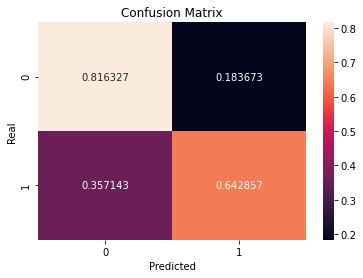

In [24]:
sklearn_tree_grid = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'max_depth': range(1,25),
    'min_samples_leaf': range(1,10),
    'min_samples_split': range(2,10)
}

sklearn_tree_params = get_best_estimator(_param_grid = sklearn_tree_grid,
                                         _estimator = DecisionTreeClassifier(random_state=42),
                                         X = X_train_SMOTE,
                                         y = y_train_SMOTE.to_numpy().flatten())

start_time = time.time()
sklearn_tree = DecisionTreeClassifier(**sklearn_tree_params, random_state=42)
sklearn_tree.fit(X_train_SMOTE, y_train_SMOTE.to_numpy().flatten())
end_time = time.time() - start_time

'''
score_model(model = sklearn_tree, 
            X = X_train_SMOTE, 
            y = y_train_SMOTE, 
            library_name = 'Sklearn', 
            algorithm_name = 'CART',
            fit_time = end_time,
            add_to_df=False)'''

score_model(model = sklearn_tree, 
            X = X_test, 
            y = y_test, 
            library_name = 'Sklearn', 
            algorithm_name = 'CART',
            fit_time = end_time)

### Sklearn Random Forest

Parameters of the best estimator:
max_depth : 5
max_features : 4
n_estimators : 200


              precision    recall  f1-score   support

           0       0.80      0.88      0.83        49
           1       0.84      0.74      0.78        42

    accuracy                           0.81        91
   macro avg       0.82      0.81      0.81        91
weighted avg       0.82      0.81      0.81        91



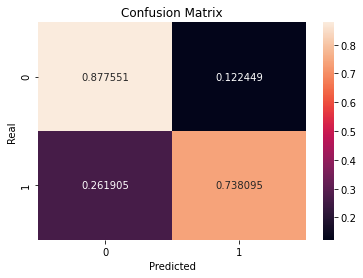

In [25]:
sklearn_forest_grid = {
    'max_features': range(4,21),
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 20, 30]
}

sklearn_forest_params = get_best_estimator(_param_grid = sklearn_forest_grid,
                                           _estimator = RandomForestClassifier(random_state=42),
                                           X = X_train_SMOTE,
                                           y = y_train_SMOTE.to_numpy().flatten(),
                                           _scoring='roc_auc')

start_time = time.time()
sklearn_forest = RandomForestClassifier(**sklearn_forest_params, random_state=42)
sklearn_forest.fit(X_train_SMOTE, y_train_SMOTE.to_numpy().flatten())
end_time = time.time() - start_time

'''score_model(model = sklearn_forest, 
            X = X_train_SMOTE, 
            y = y_train_SMOTE, 
            library_name = 'Sklearn', 
            algorithm_name = 'Random Forest', 
            fit_time = end_time,
            add_to_df = False)'''

score_model(model = sklearn_forest, 
            X = X_test, 
            y = y_test, 
            library_name = 'Sklearn', 
            algorithm_name = 'Random Forest', 
            fit_time = end_time)

# CHAPTER 4 - MODELLING USING OUR CUSTOM IMPLEMENTATION <a class="anchor" id="4"></a>

### Custom Decision tree classifier



              precision    recall  f1-score   support

           0       0.76      0.84      0.80        49
           1       0.78      0.69      0.73        42

    accuracy                           0.77        91
   macro avg       0.77      0.76      0.77        91
weighted avg       0.77      0.77      0.77        91



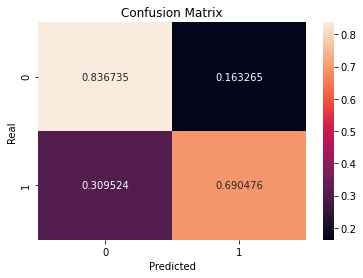

In [26]:
start_time = time.time()
custom_tree = CustomDecisionTreeClassifier(**sklearn_tree_params)
custom_tree.fit(X_train_SMOTE, y_train_SMOTE)
end_time = time.time() - start_time

'''score_model(model = custom_tree, 
            X = X_train_SMOTE, 
            y = y_train_SMOTE, 
            library_name = 'Custom', 
            algorithm_name = 'CART', 
            fit_time = end_time,
            add_to_df = False)'''

score_model(model = custom_tree, 
            X = X_test, 
            y = y_test, 
            library_name = 'Custom', 
            algorithm_name = 'CART', 
            fit_time = end_time)

### Custom Random forest classifier 



              precision    recall  f1-score   support

           0       0.79      0.86      0.82        49
           1       0.82      0.74      0.78        42

    accuracy                           0.80        91
   macro avg       0.80      0.80      0.80        91
weighted avg       0.80      0.80      0.80        91



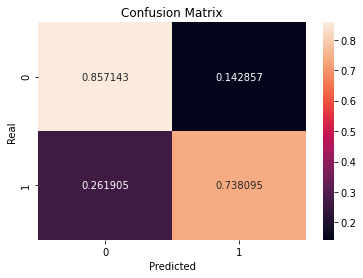

In [27]:
start_time = time.time()
custom_forest = CustomRandomForestClassifier(**sklearn_forest_params)
custom_forest.fit(X_train_SMOTE, y_train_SMOTE)
end_time = time.time() - start_time

'''score_model(model = custom_forest, 
            X = X_train_SMOTE, 
            y = y_train_SMOTE, 
            library_name = 'Custom', 
            algorithm_name = 'Random Forest', 
            fit_time = end_time,
            add_to_df = False)'''

score_model(model = custom_forest, 
            X = X_test, 
            y = y_test, 
            library_name = 'Custom', 
            algorithm_name = 'Random Forest', 
            fit_time = end_time)

# CHAPTER 5 - COMPARING RESULTS <a class="anchor" id="5"></a>

Now that we have finished building our models, we can finally compare the results of our custom implementations of the Decision Tree and Random Forest algorithms to the ones obtained by using the Sklearn implementation. As a first step, we will show the content of the `scoring_df` dataset containing all of our recorded metrics. Then, we will create a set of visual representations to show the difference in performance between our models.

In [28]:
scoring_df

,library,algorithm,pruned,accuracy,fit_time,0_precision,0_recall,0_f1_score,0_support,1_precision,...,1_f1_score,1_support,macro_avg_precision,macro_avg_recall,macro_avg_f1_score,macro_avg_support,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1_score,weighted_avg_support
0,Sklearn,CART,Not Pruned,0.736264,0.003033,0.727273,0.816327,0.769231,49,0.750000,...,0.692308,42,0.738636,0.729592,0.730769,91,0.737762,0.736264,0.733728,91
1,Sklearn,Random Forest,Not Pruned,0.813187,0.173997,0.796296,0.877551,0.834951,49,0.837838,...,0.784810,42,0.817067,0.807823,0.809881,91,0.815469,0.813187,0.811809,91
2,Custom,CART,Not Pruned,0.769231,0.035931,0.759259,0.836735,0.796117,49,0.783784,...,0.734177,42,0.771522,0.763605,0.765147,91,0.770578,0.769231,0.767529,91
3,Custom,Random Forest,Not Pruned,0.802198,2.385123,0.792453,0.857143,0.823529,49,0.815789,...,0.775000,42,0.804121,0.797619,0.799265,91,0.803224,0.802198,0.801131,91


In [29]:
def plot_algorithm_comparison(scoring_df, plot_metrics, fig_x = 25, fig_y = 10, curr_hue='library'):
    fig, ax = plt.subplots(len(plot_metrics), len(plot_metrics[0]), figsize=(fig_x, fig_y), sharey=True)

    for row in range(len(plot_metrics)):
        for column in range(len(plot_metrics[0])):
            sns.barplot(y='algorithm', 
                x=plot_metrics[row][column], 
                hue=curr_hue,
                alpha=.75,
                palette=['#d11313', '#3697b5'],
                data=scoring_df,
                ax=ax[row][column]).set_title(plot_metrics[row][column])

            ax[row,column].set_ylabel('')
            ax[row,column].set_ylabel('')
            ax[row,column].set_xlabel('')
            ax[row,column].set_xlabel('')

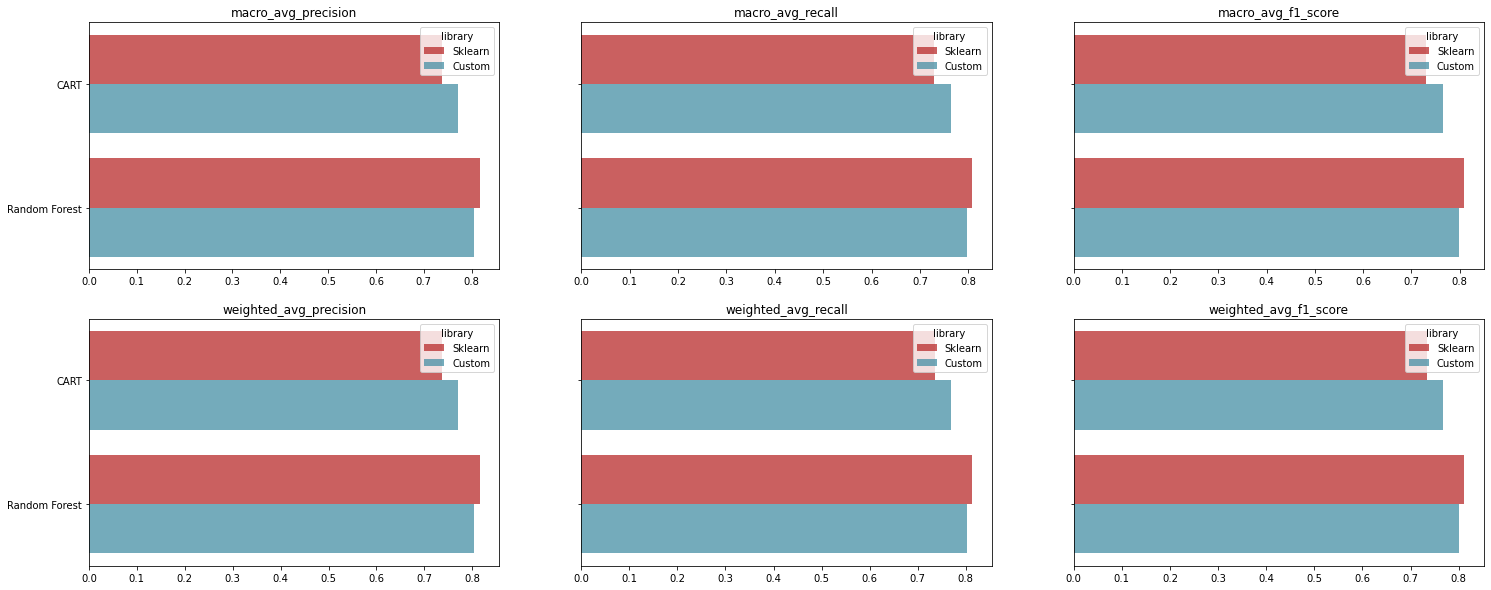

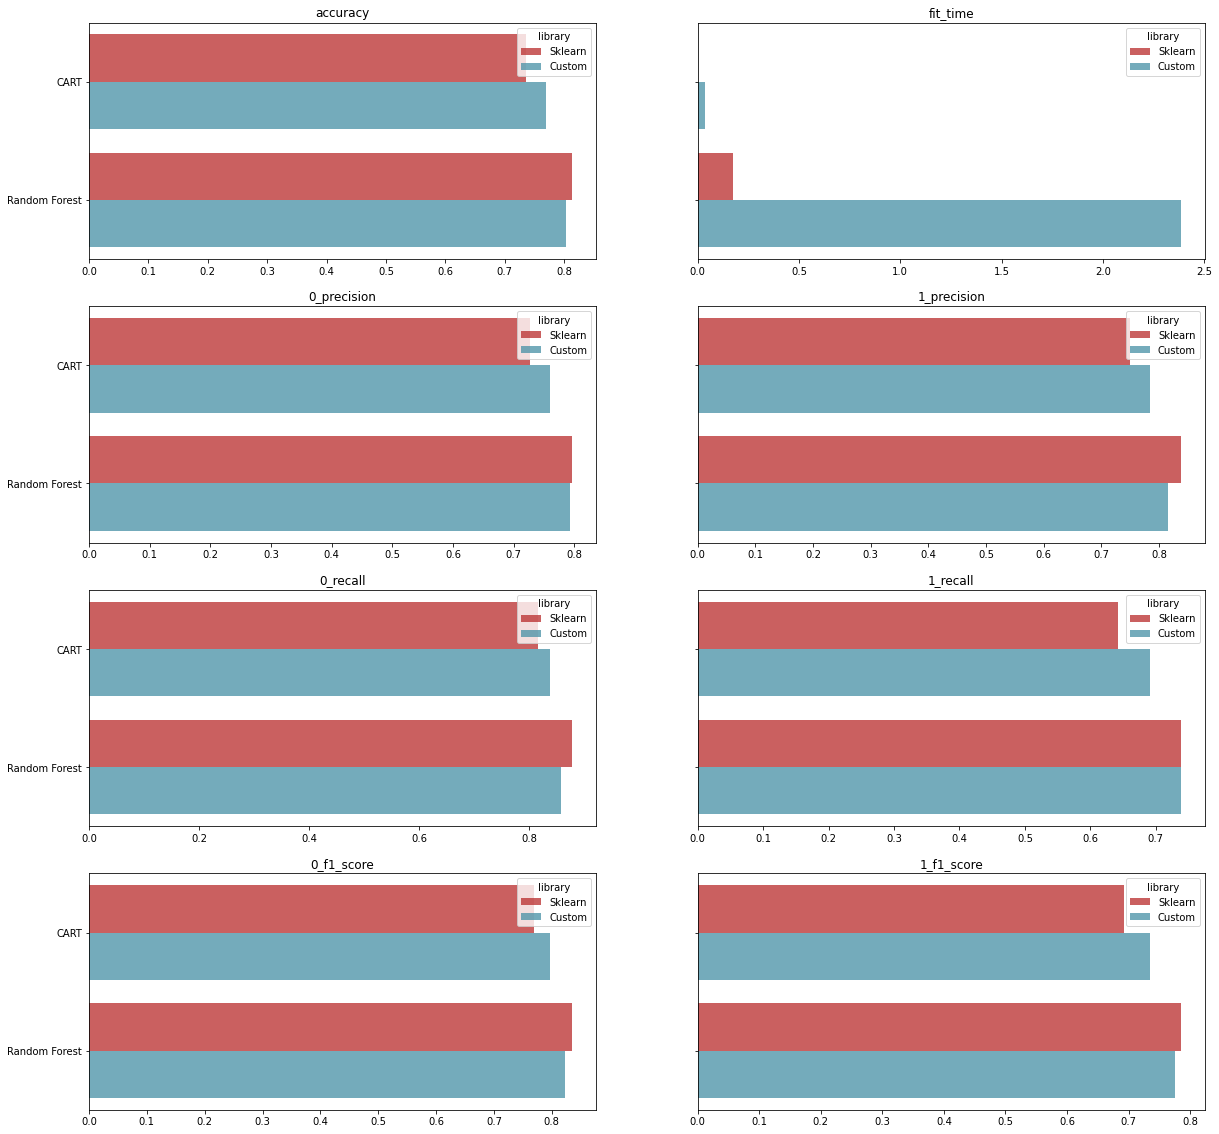

In [30]:
plot_algorithm_comparison(scoring_df,
                          [['macro_avg_precision', 'macro_avg_recall', 'macro_avg_f1_score'],
                          ['weighted_avg_precision', 'weighted_avg_recall', 'weighted_avg_f1_score']])

plot_algorithm_comparison(scoring_df,
                          [['accuracy', 'fit_time'], 
                          ['0_precision', '1_precision'],
                          ['0_recall', '1_recall'],
                          ['0_f1_score', '1_f1_score']],
                          fig_x = 20,
                          fig_y = 20)

As we can see from the plotted metrics the results of our custom implementations of the CART and Random Forest algorithms achieve comparable results across the board when put side-by-side with the implementations offered by Sklearn. The one aspect where our implementation seems to fall behind is fit time.

# CHAPTER 6 - EXTRA <a class="anchor" id="6"></a>

## Section 6.1 - Pruning with Sklearn implementation of CCP <a class="anchor" id="6.1"></a>

The cost complexity R_alpha(T) of a tree T is defined as follows:

$$ R _{\alpha} (T) = R(T) + \alpha |T| $$

Where |T| is the number of leaf nodes of T and R(T) is the total (training) error (misclassification rate) of the leaf nodes. Often times trees have a very low R(T) because they are overgrown (i.e. they overfit the training data). Alpha is called complexity parameter and it controls the nr of leaf nodes in the tree. The objective of CCP is to minimize R_alpha(T). The result of CCP is usually a model that is slightly less accurate on training data, but more capable to generalize on new data.

For a single node t, with R(t) indicating the training error (or misclassification rate) at the given node, we have that:

$$ R _{\alpha} (t) = R(t) + \alpha $$

If we now take t as the root of a sub-tree T_t, we have its training error R(T_t) defined as the sum of the training error of all its leaf nodes L:

$$ R(T _{t}) = \sum \limits _{i = 1} ^L R(t _{i}) $$

The cost complexity of T_t can be calculated as shown in the first equation:

$$ R _{\alpha} (T _{t}) = R(T _{t}) + \alpha |T _{t}| $$

Now, if the training error at a node t is equal to the training error for the sub_tree T_t (which is rooted in t):

$$ R(t) = R(T _{t}) $$

We can say that the split made at t is redundant and we can prune the sub-tree T_t. If we generalize this concept to the cost complexity measure:

$$ R _{\alpha} (t) = R _{\alpha} (T _{t}) $$

$$ R(t) + \alpha = R(T _{t}) + \alpha |T _{t}| $$

And solve for alpha, we obtain:

$$ \alpha _{effective} (t) = \frac{R(t) - R(T _{t})}{|T| - 1} $$

This values of alpha, called effective alpha, is computed for each inner node. Non-terminal nodes with the smallest effective alphas (which are the weakest links) are pruned until only the root nodes remains.

With alpha set to 0, the unpruned tree is returned. As alpha approaches infinity, only the root node is returned.

It can also be proven that:

$$ R(t) >= R(t_{L}) + R(t_{R}) $$

Hence, the effective alpha will always be >= 0

Setting the value of `ccp_alpha` (threshold for the weakest link) of the `DecisionTreeClassifier` will cause the tree to be pruned until the trees smallest effective alpha reaches `ccp_alpha`. The method `cost_complexity_pruning_path` performs the pruning process and returns the set of effective alphas (and impurities) of a given tree.

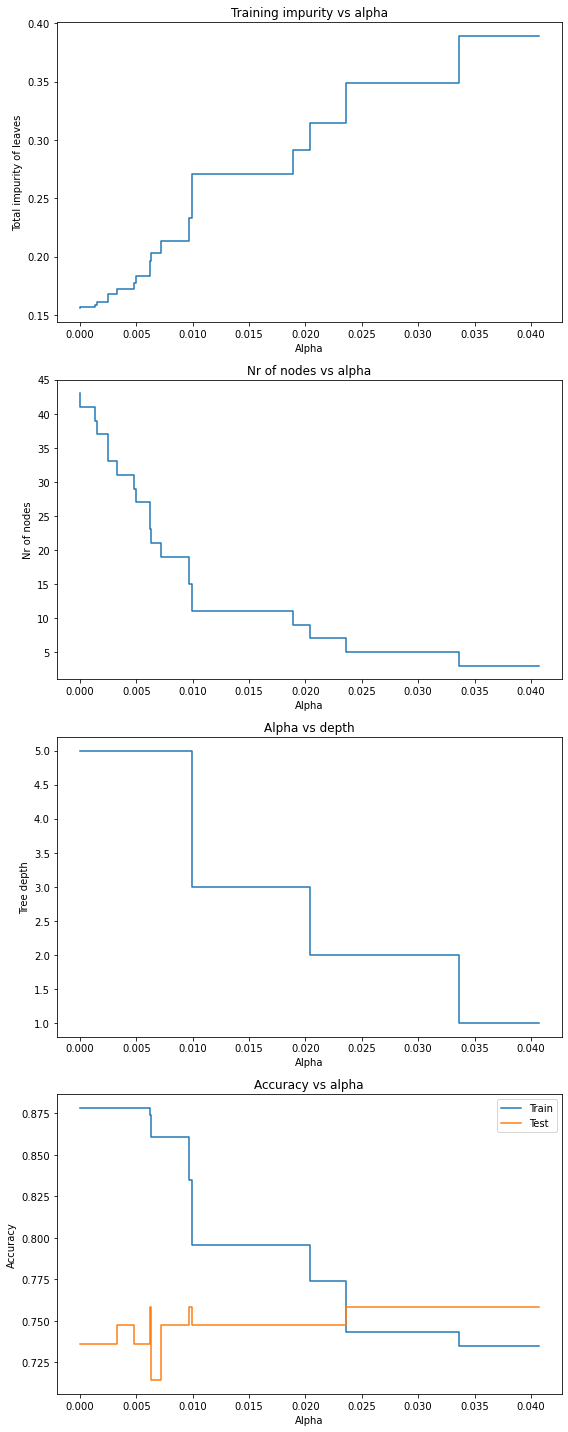

In [31]:
path = DecisionTreeClassifier(**sklearn_tree_params, random_state=42).cost_complexity_pruning_path(X_train_SMOTE, y_train_SMOTE)

# CCP alphas of subtrees + Sum of impurities of each subtree leaves
ccp_alphas, impurities = path.ccp_alphas, path.impurities 

# Test the decision tree with all CCP alphas
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(**sklearn_tree_params, ccp_alpha=ccp_alpha, random_state=42)
    clf.fit(X_train_SMOTE, y_train_SMOTE)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(4, 1, figsize=(8, 20))

sns.lineplot(x=ccp_alphas, y=impurities[:-1], drawstyle='steps-pre', ax=ax[0])
ax[0].set(xlabel='Alpha', ylabel='Total impurity of leaves', title='Training impurity vs alpha')

sns.lineplot(x=ccp_alphas, y=node_counts,  drawstyle='steps-pre', ax=ax[1])
ax[1].set(xlabel='Alpha', ylabel='Nr of nodes', title='Nr of nodes vs alpha')

sns.lineplot(x=ccp_alphas, y=depth,  drawstyle='steps-pre', ax=ax[2])
ax[2].set(xlabel='Alpha', ylabel='Tree depth', title='Alpha vs depth')

train_scores = [accuracy_score(y_train_SMOTE, clf.predict(X_train_SMOTE)) for clf in clfs]
test_scores = [accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

sns.lineplot(x=ccp_alphas, y=train_scores, drawstyle='steps-pre', label='Train', ax=ax[3])
sns.lineplot(x=ccp_alphas, y=test_scores,  drawstyle='steps-pre', label='Test', ax=ax[3])
ax[3].set(xlabel='Alpha', ylabel='Accuracy', title='Accuracy vs alpha')
ax[3].legend()

fig.tight_layout()
plt.show()

We will now apply one of the optimal values of `ccp_alpha` to both the `DecisionTreeClassifier` and the `RandomForestClassifier`. As stated in one of the previous sections, cost complexity pruning will mostly benefit our decision tree model, leading only to minor to non-existent benefits to the random forest classifier 

In [32]:
start_time = time.time()
pruned_sklearn_tree = DecisionTreeClassifier(**sklearn_tree_params, ccp_alpha = 0.010, random_state=42)
pruned_sklearn_tree.fit(X_train_SMOTE, y_train_SMOTE.to_numpy().flatten())
end_time = time.time() - start_time

score_model(model=pruned_sklearn_tree, 
            X=X_test,
            y=y_test,
            library_name='Sklearn',
            algorithm_name='CART',
            fit_time=end_time,
            pruned=True,
            verbose = False)

start_time = time.time()
pruned_sklearn_forest = RandomForestClassifier(**sklearn_forest_params, ccp_alpha = 0.010, random_state=42)
pruned_sklearn_forest.fit(X_train_SMOTE, y_train_SMOTE.to_numpy().flatten())
end_time = time.time() - start_time

score_model(model = pruned_sklearn_forest, 
            X = X_test, 
            y = y_test, 
            library_name = 'Sklearn', 
            algorithm_name = 'Random Forest', 
            fit_time = end_time,
            pruned=True,
            verbose=False)

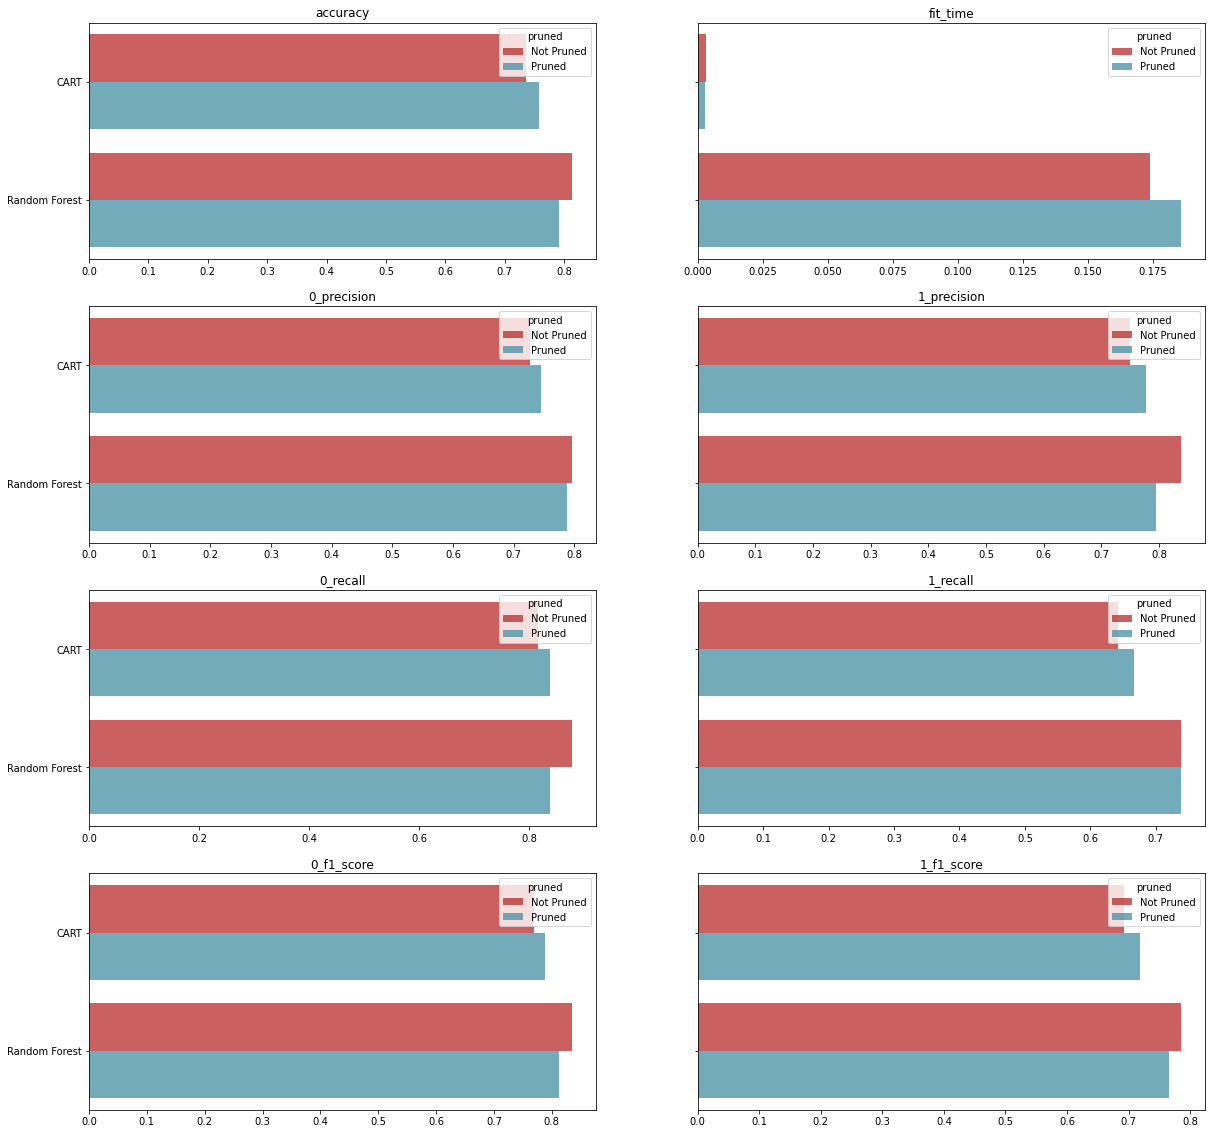

In [33]:
plot_algorithm_comparison(scoring_df[scoring_df['library'] == 'Sklearn'],
                          [['accuracy', 'fit_time'],
                          ['0_precision', '1_precision'],
                          ['0_recall', '1_recall'],
                          ['0_f1_score', '1_f1_score']],
                          fig_x = 20,
                          fig_y = 20,
                          curr_hue='pruned')

These metrics confirmed our expectations regarding the effectnivness of CCP. For the `DecisionTreeClassifier` we have seen improvements for both classes across all metrics. On the other hand, the application of this technique on the `RandomForestClassifier` only lead to fairly inconsistent improvements in relation to the non-pruned model. This observation is additional proof that feature randomness and bagging are already addressing the high-variance typical of decision trees.

## Section 6.2 - Visual representation of pruned & non-pruned Decision Tree <a class="anchor" id="6.2"></a>

As a last step before our concluding statement, we will plot both the various version of the Sklearn-based `DecisionTreeClassifier`.

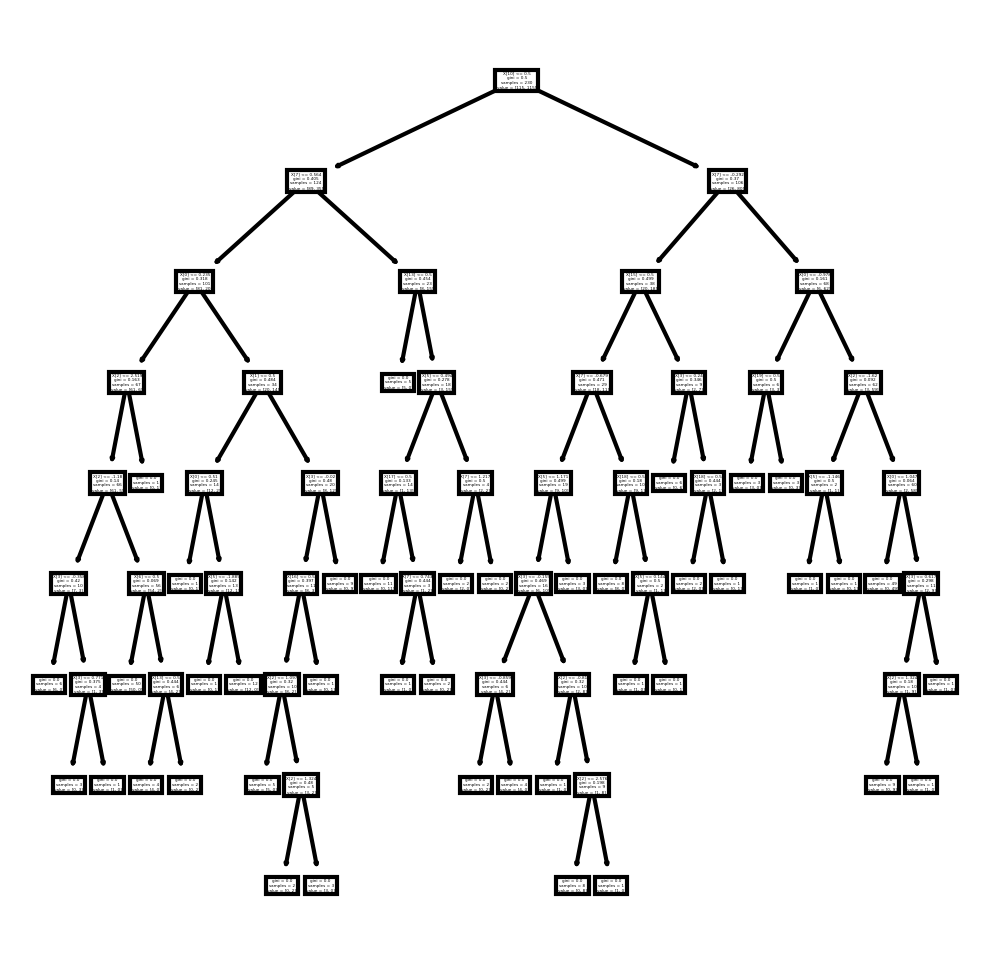

In [34]:
# Completely unpruned
start_time = time.time()
non_pruned_sklearn_tree = DecisionTreeClassifier(random_state=42)
non_pruned_sklearn_tree.fit(X_train_SMOTE, y_train_SMOTE.to_numpy().flatten())
end_time = time.time() - start_time

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(non_pruned_sklearn_tree)
fig.savefig('images/non-pruned-tree.png')

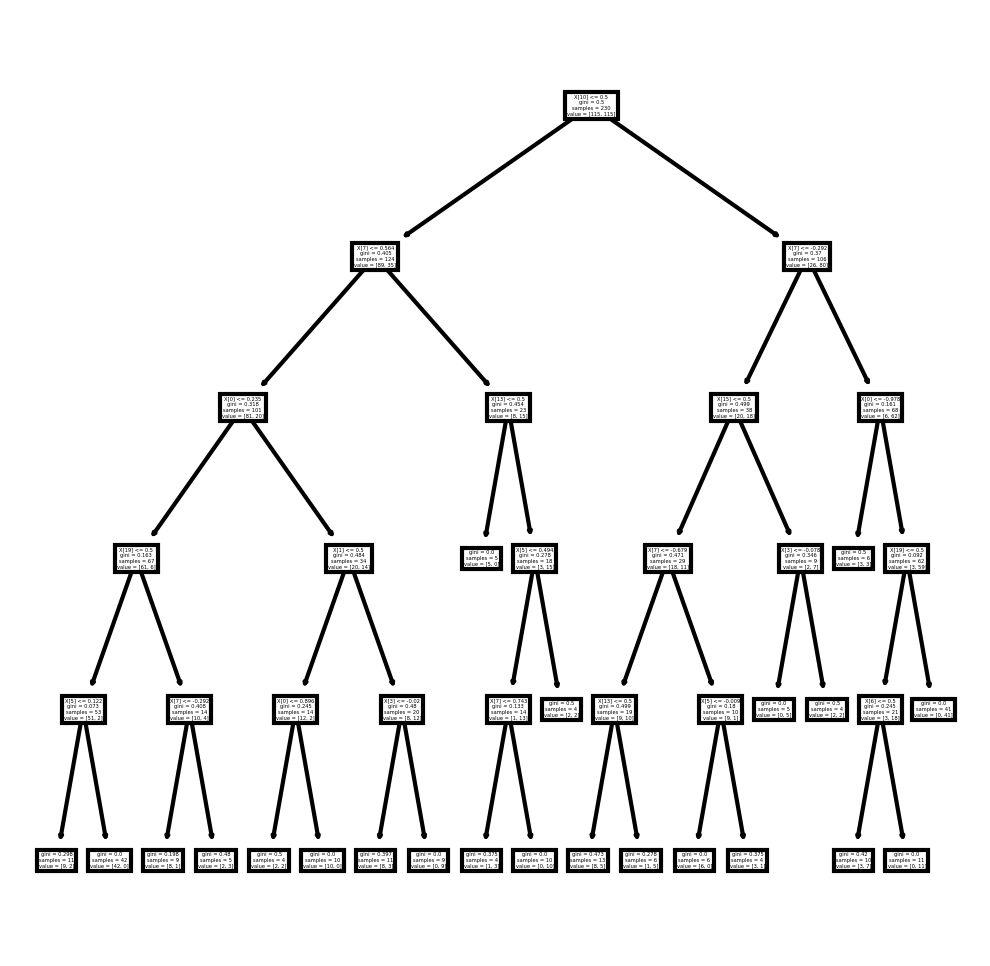

In [35]:
# Pre-pruned
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(sklearn_tree)
fig.savefig('images/pre-pruned-tree.png')

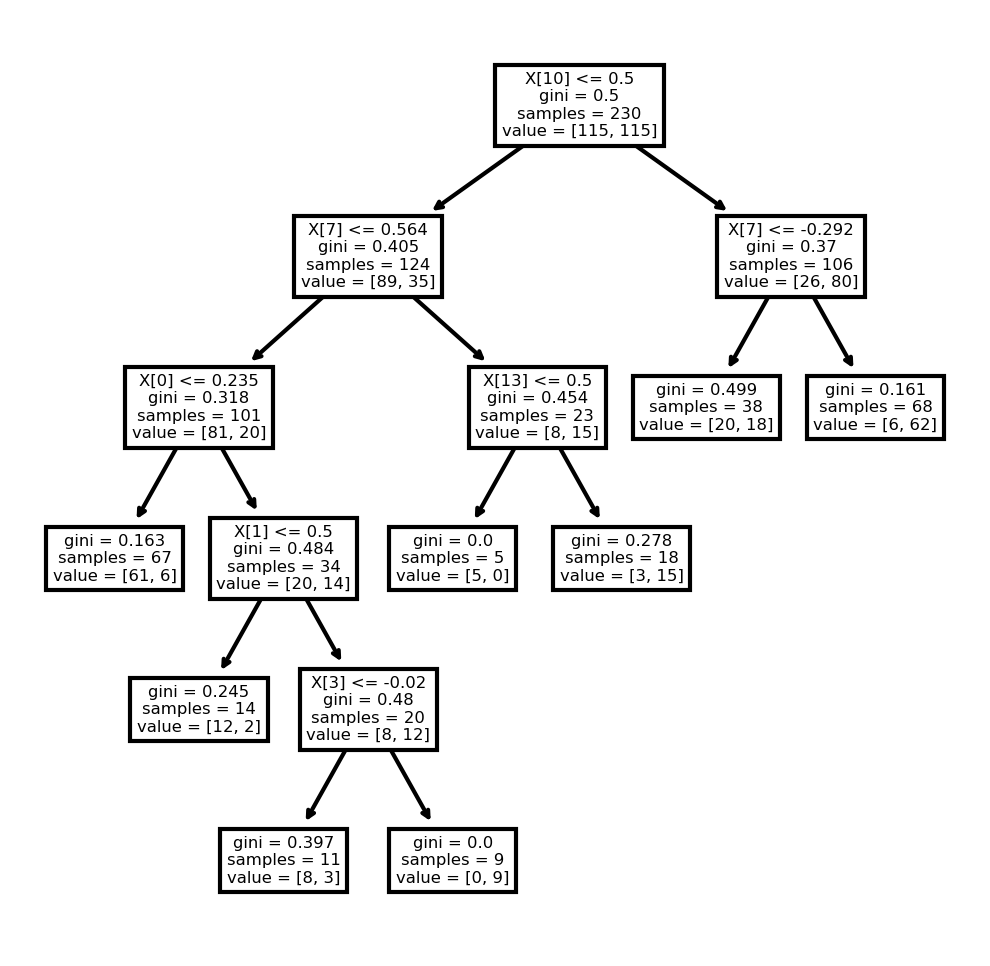

In [36]:
# Pre- and Post-Pruned
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(pruned_sklearn_tree)
fig.savefig('images/pre-post-pruned-tree.png')

# CHAPTER 7 - CONCLUSIONS & FUTURE WORK <a class="anchor" id="7"></a>

We set out to create this project with the main intent of developing a better understanding of the inner-workings of tree-based algorithms. In order to achieve this goal we decided to develop a custom implementation of the CART and Random Forest algorithms. This allowed us to closely look at each step involved in the creation of machine learning models starting from this particular set of techniques. We were also able to compare our results with the existing implementation of said algorithms offered by the Sklearn library on a dataset coming from the medical domain (the Cleveland Heart Disease dataset). We were pleased to see that our work scored comparably to the baseline established by the Sklearn library.

After the completion of this project we were able to recognize certain topics that could be later explored in our future work. In particular, further improvements in the context of this work could be directed towards:
 - Researching some optimization techniques to reduce the time needed to build a machine learning model using the `CustomDecisionTreeClassifier` and `CustomRandomForestClassifier`
 - Introduce a way to perform cost complexity pruning in our custom algorithm
 - Develop a version of CART and Random Forest for regression